In [1]:
import os
import json
import glob
import copy
import importlib
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import dill as pkl

from scipy import stats as spstats
from matplotlib.lines import Line2D
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
%matplotlib notebook

In [3]:
from analyze2p.utils import plotting as pplot
from analyze2p.utils import helpers as hutils
import analyze2p.aggregate_datasets as aggr

from analyze2p.utils import gratings as gutils

# from analyze2p.utils import rfs as rfutils
# from analyze2p.utils import rois as roiutils
# from analyze2p.utils import retino as retutils

In [4]:
# Set colors
visual_areas, area_colors = pplot.set_threecolor_palette()
dpi = pplot.set_plot_params()
pl.rcParams['axes.labelsize']

6.0

# Set Source Data

In [5]:
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

experiment = 'gratings'
response_type='dff'
responsive_test='nstds'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
n_stds=2.5
n_bootstrap_iters=1000
n_resamples=20
print(responsive_test, responsive_thr)

#### Responsive params
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, 
                            responsive_test=responsive_test, 
                            n_stds=n_stds, responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters, 
                            n_resamples=n_resamples)
data_id = '|'.join([traceid, ori_fit_desc])
print(data_id)

nstds 10.0
traces001|fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


# Output dir

In [6]:
#### Source dirs
stats_dir = os.path.join(aggregate_dir, 'data-stats')

#### Output dir
pupildir = os.path.join(aggregate_dir, 'behavior-state', 'pupil')
print(pupildir)

if not os.path.exists(pupildir):
    os.makedirs(pupildir)

/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/pupil


In [7]:
os.listdir(pupildir)

['20190622_JC085_fov1_config006_sorted_neurons_pupil_trace_20trials_bin20fHz.png',
 '20190622_JC085_fov1_sorted_neurons_pupil_trace_20trials_bin20fHz.png',
 '20190616_JC097_fov1_config003_sorted_neurons_pupil_trace_20trials_bin20fHz.png',
 'gratings_20190522_JC084_fov1_config022_sorted_neurons_pupil_trace_20trials_bin20fHz.png']

# Get metadata

In [8]:
# #### Get metadata for experiment type
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
# cells, missing_seg = aggr.get_cells_by_area(sdata, return_missing=True)
meta = sdata[sdata.experiment.isin([experiment])].copy()

all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in all_dkeys])
CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates().groupby(['visual_area']).count()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets


animalid  session  fovnum
visual_area                           
Li                 15       15      15
Lm                 11       11      11
V1                  9        9       9

# Load trial data

In [9]:
#### Load neural responses
trial_epoch='plushalf'
responsive_test='nstds' #'roc'
responsive_thr=10.
response_type='dff'

NDATA = aggr.get_aggregate_data(experiment, traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, verbose=False,
                      responsive_thr=responsive_thr, n_stds=n_stds)
NDATA[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['gratings']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl


datakey
visual_area         
Li                15
Lm                10
V1                 9

# Face tracker data

#### Check which datakeys are missing DLC -- ALL data

In [10]:
# Get sdata indices that have experiments analyzed
def check_missing_dlc(sdata,
            face_src_dir='/n/coxfs01/julianarhee/face-tracking',
            dlc_project='facetracking-jyr-2020-01-25'):
    dlc_results_dir = os.path.join(face_src_dir, dlc_project, 'pose-analysis')
    print("Checking for existing results: %s" % dlc_results_dir)
    dlc_runkeys = list(set([ os.path.split(f)[-1].split('DLC')[0] \
                       for f in glob.glob(os.path.join(dlc_results_dir, '*.h5'))]))
    dlc_analyzed_experiments = ['_'.join(s.split('_')[0:4]) for s in dlc_runkeys]

    ixs_wth_dlc = [i for i in sdata.index.tolist() 
                    if '%s_%s' % (sdata.loc[i]['datakey'], sdata.loc[i]['experiment']) \
                   in dlc_analyzed_experiments]

    dlc_dsets = sdata.loc[ixs_wth_dlc]
    dlc_datakeys = dlc_dsets['datakey'].unique()
    all_datakeys = sdata['datakey'].unique()
    print("%i of %i datasets with DLC." % (len(dlc_datakeys),len(all_datakeys)))
    missing_dlc = [i for i in all_datakeys if i not in dlc_datakeys]
    
    return dlc_dsets, missing_dlc

In [11]:
face_src_dir='/n/coxfs01/julianarhee/face-tracking'
dlc_project='facetracking-jyr-2020-01-25'

dlc_dsets, missing_dlc = check_missing_dlc(meta)    
print("Need %i datasets analyzed:" % (len(missing_dlc)))
for m in missing_dlc:
    print('    %s' % m)

Checking for existing results: /n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/pose-analysis
26 of 31 datasets with DLC.
Need 5 datasets analyzed:
    20190314_JC070_fov1
    20190315_JC070_fov2
    20190319_JC067_fov1
    20190306_JC061_fov2
    20190314_JC070_fov2


In [12]:
dlc_dsets.groupby(['visual_area']).count()

experiment  datakey  fov  animalid  session  fovnum
visual_area                                                     
Li                   12       12   12        12       12      12
Lm                    9        9    9         9        9       9
V1                    9        9    9         9        9       9

# Loading existing extracted pupil data

In [13]:
from analyze2p.arousal import dlc_utils as dlcutils
from analyze2p.arousal import parse_face_data as pdlc

In [16]:
# Pupil -------------------------------------------
pupil_feature='pupil_fraction'
pupil_epoch='stimulus'
pupil_snapshot=391800
redo_pupil=False
pupil_framerate=20.
# -------------------------------------------------
alignment_type='trial'

In [36]:
importlib.reload(dlcutils)

<module 'analyze2p.arousal.dlc_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/arousal/dlc_utils.py'>

In [37]:
# pupil_feature='pupil_area'
# create_new=True
# Load pupil traces (for plotting)
pupiltraces, missing_dsets = dlcutils.get_aggregate_traces(experiment, 
                                            feature_name=pupil_feature,
                                            alignment_type=alignment_type,
                                            traceid=traceid, 
                                            create_new=True, redo_fov=False,
                                            return_missing=True)

... loading existing
Aggr. traces not found:
    /n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/traces_pupil_fraction_align-trial_gratings_snapshot-391800.pkl
... aggregate traces anew
~~~~~ Aggregating pupil traces. ~~~~~~
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
    results do not exist:
    /n/coxfs01/2p-data/JC061/20190306/FOV2_zoom2p0x/combined_gratings_static/facetracker/traces_pupil_area_align-trial_gratings_snapshot-391800.pkl
... missing traces: 20190306_JC061_fov2
    results do not exist:
    /n/coxfs01/2p-data/JC067/20190319/FOV1_zoom2p0x/combined_gratings_static/facetracker/traces_pupil_area_align-trial_gratings_snapshot-391800.pkl
... missing traces: 20190319_JC067_fov1
    results do not exist:
    /n/coxfs01/2p-data/JC070/20190314/FOV1_zoom2p0x/combined_gratings_static/facetracker/traces_pupil_area_align-trial_gratings_snapshot-391800.pkl
... missing traces: 20190314_JC070_fov1
    results do not exist:
    /n/coxfs01/2p-data

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/arousal/dlc_utils.py", line 232, in get_aggregate_traces
    return_missing=True)
TypeError: cannot unpack non-iterable NoneType object


Aggregated pupil traces. Missing 8 datasets.


In [41]:
pupiltraces['20190513_JC078_fov1']

pupil     config  trial  stim_dur_ms  pre_iti_ms  post_iti_ms  \
0   12.838607  config022      1       1000.0      1000.0       1000.0   
1   12.817773  config022      1       1000.0      1000.0       1000.0   
2   12.788489  config022      1       1000.0      1000.0       1000.0   
3   12.717805  config022      1       1000.0      1000.0       1000.0   
4   12.712529  config022      1       1000.0      1000.0       1000.0   
..        ...        ...    ...          ...         ...          ...   
16  10.693392  config029    960       1000.0      1000.0       1000.0   
17  10.767705  config029    960       1000.0      1000.0       1000.0   
18  10.724060  config029    960       1000.0      1000.0       1000.0   
19  10.664538  config029    960       1000.0      1000.0       1000.0   
20  10.573402  config029    960       1000.0      1000.0       1000.0   

    actual_iti_ms  
0          2000.0  
1          2000.0  
2          2000.0  
3          2000.0  
4          2000.0  
..            ...  
16         2000.0  
17         2000.0  
18         2000.0  
19         2000.0  
20         2000.0  

[20129 rows x 7 columns]

TypeError: float() argument must be a string or a number, not 'list'

In [30]:
# fn = '/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/combined_gratings_static/facetracker/traces_pupil_area_align-trial_gratings_snapshot-391800.pkl'
# with open(fn, 'rb') as f:
#     r = pkl.load(f)
# r
dlcutils.create_parsed_traces_id(experiment=experiment, 
                                 alignment_type=alignment_type,
                                 feature_name=pupil_feature)


'traces_pupil_fraction_align-trial_gratings_snapshot-391800'

In [31]:
r

pupil     config  trial  stim_dur_ms  pre_iti_ms  post_iti_ms  \
0   5.102807  config030      1        500.0      1000.0       1000.0   
1   5.094471  config030      1        500.0      1000.0       1000.0   
2   5.142530  config030      1        500.0      1000.0       1000.0   
3   5.183729  config030      1        500.0      1000.0       1000.0   
4   4.960880  config030      1        500.0      1000.0       1000.0   
..       ...        ...    ...          ...         ...          ...   
6   7.591975  config027   1280        500.0      1000.0       1000.0   
7   7.580658  config027   1280        500.0      1000.0       1000.0   
8   7.537055  config027   1280        500.0      1000.0       1000.0   
9   7.530542  config027   1280        500.0      1000.0       1000.0   
10  7.505814  config027   1280        500.0      1000.0       1000.0   

    actual_iti_ms  
0          2000.0  
1          2000.0  
2          2000.0  
3          2000.0  
4          2000.0  
..            ...  
6          2000.0  
7          2000.0  
8          2000.0  
9          2000.0  
10         2000.0  

[14057 rows x 7 columns]

In [110]:
# Aggregate dataframes
save_fname = dlcutils.create_dataframes_name(experiment, feature_name, 
                                             pupil_epoch, snapshot=pupil_snapshot)
print(save_fname)

if create_new:
    pupildata = dlcutils.aggregate_pupil_dataframes(pupiltraces, 
                            save_fname, feature_name=feature_name, 
                            trial_epoch=pupil_epoch, 
                            in_rate=pupil_framerate, out_rate=pupil_framerate,
                            iti_pre=iti_pre, iti_post=iti_post, stim_dur=stim_dur)
missing_dsets


metrics_gratings_pupil_fraction_stimulus_snapshot-391800
~~~~~~~~~~~~ Aggregating pupil dataframes. ~~~~~~~~~~~


['20190306_JC061_fov2',
 '20190319_JC067_fov1',
 '20190314_JC070_fov1',
 '20190314_JC070_fov2',
 '20190315_JC070_fov2',
 '20190522_JC089_fov1',
 '20190612_JC099_fov1']

In [111]:
check_ = ['20190306_JC061_fov3', '20190322_JC073_fov1']
for k in check_:
    print(k, k in pupildata.keys())


20190306_JC061_fov3 False
20190322_JC073_fov1 False


In [41]:
pupildata['20190322_JC073_fov1'].head()

KeyError: '20190322_JC073_fov1'

In [115]:
#### Save aggregate dataframe
fname = dlcutils.create_dataframes_name(experiment, feature_name, pupil_epoch, pupil_snapshot)
pupildf_fpath = os.path.join(aggregate_dir, 'behavior-state', '%s.pkl' % fname)
print(pupildf_fpath)
with open(pupildf_fpath, 'wb') as f:
    pkl.dump(pupildata, f, protocol=pkl.HIGHEST_PROTOCOL)
print("---> Saved aggr dataframes: %s" % pupildf_fpath)


/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/metrics_blobs_pupil_fraction_pre_snapshot-391800.pkl
---> Saved aggr dataframes: /n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/metrics_blobs_pupil_fraction_pre_snapshot-391800.pkl


In [92]:
feature_name, pupil_epoch, alignment_type, iti_pre, iti_post, stim_dur

('pupil_fraction', 'pre', 'trial', 1.0, 1.0, 1.0)

In [136]:
reload(dlcutils)

<module 'pipeline.python.eyetracker.dlc_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/eyetracker/dlc_utils.py'>

In [137]:
#### Get pupil responses
#if 'pupil' in analysis_type:
feature_to_load = 'pupil_area' if feature_name=='pupil_fraction' else feature_name
pupildata, missing_dsets_df = dlcutils.get_aggregate_pupildfs(experiment=experiment, 
                                        feature_name=feature_name, 
                                        alignment_type=alignment_type,
                                        trial_epoch=pupil_epoch,
                                        iti_pre=iti_pre, iti_post=iti_post, stim_dur=stim_dur,
                                        in_rate=pupil_framerate, out_rate=pupil_framerate,
                                        snapshot=pupil_snapshot, create_new=False, return_missing=True)
missing_dsets_df

>>>> Loaded aggregate pupil dataframes.
Segmentation: missing 9 dsets
Creating new aggr dataframe...
~~~~~ Aggregating pupil traces. ~~~~~~
Segmentation: missing 9 dsets
Aggregated pupil traces. Missing 1 datasets.
~~~~~~~~~~~~ Aggregating pupil dataframes. ~~~~~~~~~~~
---> Saved aggr dataframes: /n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/metrics_blobs_pupil_fraction_pre_snapshot-391800.pkl


['20190315_JC070_fov1']

In [139]:
sorted(pupildata.keys())

['20190306_JC061_fov3',
 '20190314_JC070_fov1',
 '20190316_JC070_fov1',
 '20190319_JC067_fov1',
 '20190320_JC067_fov1',
 '20190321_JC070_fov1',
 '20190322_JC073_fov1',
 '20190327_JC073_fov1',
 '20190420_JC076_fov1',
 '20190422_JC076_fov1',
 '20190430_JC078_fov1',
 '20190501_JC076_fov1',
 '20190504_JC078_fov1',
 '20190506_JC080_fov1',
 '20190507_JC083_fov1',
 '20190508_JC083_fov1',
 '20190509_JC078_fov1',
 '20190510_JC083_fov1',
 '20190511_JC083_fov1',
 '20190512_JC083_fov1',
 '20190513_JC078_fov1',
 '20190517_JC083_fov1',
 '20190522_JC084_fov1',
 '20190525_JC084_fov1',
 '20190602_JC091_fov1',
 '20190603_JC080_fov1',
 '20190606_JC091_fov1',
 '20190607_JC091_fov1',
 '20190609_JC099_fov1',
 '20190612_JC099_fov1',
 '20190613_JC097_fov1',
 '20190614_JC091_fov1',
 '20190616_JC097_fov1',
 '20190617_JC097_fov1',
 '20190617_JC099_fov1',
 '20190618_JC097_fov1',
 '20190622_JC085_fov1',
 '20190627_JC091_fov1',
 '20191006_JC110_fov1',
 '20191018_JC113_fov1',
 '20191111_JC120_fov1']

In [109]:
reload(dlcutils)

<module 'pipeline.python.eyetracker.dlc_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/eyetracker/dlc_utils.py'>

In [140]:
### Test loading from classifications.decode_by_ncells.py() (analysis_type='split_pupil')
# Pupil -------------------------------------------
pupil_feature='pupil_fraction'
pupil_alignment='trial'
pupil_epoch='pre'
pupil_snapshot=391800
redo_pupil=False
pupil_framerate=20.
pupil_quantiles=3.

pupildata = dlcutils.get_aggregate_pupildfs(experiment=experiment,
                                    alignment_type=pupil_alignment,
                                    feature_name=pupil_feature, trial_epoch=pupil_epoch,
                                    iti_pre=iti_pre, iti_post=iti_post, stim_dur=stim_dur,
                                    in_rate=pupil_framerate, out_rate=pupil_framerate,
                                    snapshot=pupil_snapshot, create_new=False)

>>>> Loaded aggregate pupil dataframes.
Segmentation: missing 9 dsets
Creating new aggr dataframe...
~~~~~ Aggregating pupil traces. ~~~~~~
Segmentation: missing 9 dsets
Aggregated pupil traces. Missing 1 datasets.
~~~~~~~~~~~~ Aggregating pupil dataframes. ~~~~~~~~~~~
---> Saved aggr dataframes: /n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/metrics_blobs_pupil_fraction_pre_snapshot-391800.pkl


In [141]:
'20190322_JC073_fov1' in pupildata.keys()

True

In [98]:
pupildata.keys()


[]

In [54]:
missing_dsets

['20190315_JC070_fov1', '20190321_JC070_fov1', '20190322_JC073_fov1']

In [57]:
'20190306_JC061_fov3' in pupildata.keys()


True

In [55]:
alignment_type, feature_name, iti_pre, iti_post

('trial', 'pupil_area', 1.0, 1.0)

In [41]:
animalid='JC073'
session = '20190322'
fov='FOV1_zoom2p0x'
ptraces, params = pdlc.parse_pose_data(animalid, session, fov, experiment,
                        traceid=traceid,
                        iti_pre=iti_pre, iti_post=iti_post,
                        feature_name=feature_name,
                        alignment_type=alignment_type) #,
                        #snapshot=snapshot,
                        #rootdir=rootdir,
                        #eyetracker_dir=eyetracker_dir)

Saving output to: /n/coxfs01/2p-data/JC073/20190322/FOV1_zoom2p0x/combined_blobs_static/facetracker
['/n/coxfs01/2p-data/JC073/20190322/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_81e79a_traces001_f6d36b_traces001_ce6f87_traces001_45c4e4_traces001_86650c_traces001_bec664']
Loading pose data (dlc)
('[blobs] Found runs:', ['1', '2', '3', '4', '5', '6'])
... finding movies for dset: 20190322_JC073_fov1
(0, '/n/coxfs01/2p-data/eyetracker_tmp/20190322_JC073_fov1_blobs_f1_20190322164846172773')
(1, '/n/coxfs01/2p-data/eyetracker_tmp/20190322_JC073_fov1_blobs_f2_20190322172255882616')
(2, '/n/coxfs01/2p-data/eyetracker_tmp/20190322_JC073_fov1_blobs_f3_20190322183451456336')
(3, '/n/coxfs01/2p-data/eyetracker_tmp/20190322_JC073_fov1_blobs_f3_20190322183613092256')
(4, '/n/coxfs01/2p-data/eyetracker_tmp/20190322_JC073_fov1_blobs_f4_20190322190633689537')
(5, '/n/coxfs01/2p-data/eyetracker_tmp/20190322_JC073_fov1_blobs_f5_20190322193838774076')
(6, '/n/coxfs01/2p-data/eyetracker_tmp/201

AssertionError: incorrect match: 20190322_JC073_fov1_blobs_f3_20190322183613092256 / 20190322_JC073_fov1_blobs_f4DLC_resnet_50_facetrackingJan25shuffle1_391800.h5

# Select dataset (example FOV)

In [119]:
#datakey = '20190616_JC097_fov1'
datakey = '20190522_JC084_fov1'
visual_area='V1'
session, animalid, fovn = datakey.split('_')
fovnum = 1 #int(fovn[3:])

if experiment == 'blobs':
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
else:
    obj = util.Gratings(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
sdf = obj.get_stimuli()
print(sdf.shape)

(64, 11)


In [120]:
include_stimuli='all'
all_configs = ['config%03d' % i for i in np.arange(1, sdf.shape[0]+1)]
if experiment=='blobs':
    control_configs = ['config001', 'config002', 'config003', 'config004', 'config005']
elif experiment=='gratings':
    control_configs = sdf[sdf['size']>100].index.tolist()
    
if include_stimuli=='fullscreen':
    included_configs = [c for c in all_configs if c in control_configs]
elif include_stimuli=='image':
    included_configs = [c for c in all_configs if c not in control_configs]
elif include_stimuli=='all':
    included_configs = all_configs
else:
    print("UNKNOWN: %s" % include_stimuli)
print("Restricting stimuli to: %s (%i conditions)" % (include_stimuli, len(included_configs)))

Restricting stimuli to: all (64 conditions)


In [121]:
# Get neural means
print(datakey)
# neuraldf = MEANS[datakey].copy()
# print(neuraldf.shape)

curr_rois = cells[cells['datakey']==datakey]['cell'].values
# curr_cols = list(curr_rois.copy())
# neuraldf = MEANS[datakey][curr_cols].copy()
# neuraldf['config'] = MEANS[datakey]['config'].copy()
# print(neuraldf.shape)
pupildf = pupildata[datakey].copy()
neuraldf = aggr.get_neuraldf_for_cells_in_area(cells, MEANS, datakey=datakey, visual_area=visual_area)
print(neuraldf.shape, pupildf.shape)

# Get pupil traces
ptraces = pupiltraces['%s' % (datakey)].copy()
ptraces = ptraces[ptraces['trial'].isin(pupildf['trial'].unique())]
print(ptraces.shape)
ptraces.head()


20190522_JC084_fov1
((1088, 116), (1240, 6))
(61981, 3)


config  pupil_area  trial
0  config024  151.189627      1
1  config024  154.561072      1
2  config024  151.845837      1
3  config024  150.629278      1
4  config024  149.412676      1

In [122]:
ptraces.shape

(61981, 3)

In [123]:
ptraces = ptraces[ptraces['trial'].isin(pupildf['trial'].unique())]
ptraces.shape

(61981, 3)

In [124]:
neuraldf, pupildf = dlcutils.match_neural_and_pupil_trials(neuraldf, pupildf, equalize_conditions=True)
print(neuraldf.shape, pupildf.shape)

((1088, 116), (1088, 6))


# Downsample and align traces

In [125]:
print("Loading <%s> traces: test=%s, thr=%.3f" % (response_type, responsive_test, responsive_thr))

#### Load traces of responsive cells
traces, labels_all, sdf = aggr.load_traces(animalid, session, fovnum, experiment, traceid=traceid, 
                                         response_type=response_type,
                                         responsive_test=responsive_test, 
                                         responsive_thr=responsive_thr)
trial_key = dict((int(t[5:]), g['config'].unique()[0]) for t, g in labels_all.groupby(['trial']))
roi_list = traces.columns.tolist()

Loading <dff> traces: test=nstds, thr=10.000
... (JC084|20190522) getting responsive cells (test: nstds, thr: 10.00')
... loading stats
... 115 of 260 cells responsive


In [126]:
labels_all['trial_num'] = [int(t[5:]) for t in labels_all['trial']]
trials_with_pupil = list(ptraces['trial'].unique())
labels = labels_all[labels_all['trial_num'].isin(trials_with_pupil)].copy()
labels.shape, labels_all.shape

((138880, 9), (138880, 9))

In [127]:
# Get trial alignment info
alignment_info = aggr.get_trial_alignment(animalid, session, fovnum, experiment, traceid=traceid)
# alignment_info

In [128]:
alignment_info

{u'custom_mw': False,
 u'framerate': 44.6528,
 u'iti_full': 2.0,
 u'iti_post': 1.0,
 u'iti_pre': 1.0,
 u'nframes_iti_full': 89,
 u'nframes_iti_post': 45,
 u'nframes_iti_pre': 45,
 u'nframes_on': 22,
 u'nframes_post_onset': 67,
 u'one_to_one': False,
 u'stim_on_sec': 0.5,
 u'vols_per_trial': 112,
 u'volumerate': 44.6528}

In [129]:
# Temporal binning params
new_framerate = 20.0
framerate = 44.65

#n_frames_bin = np.ceil(framerate/new_framerate) #11.
#new_framerate = (framerate/n_frames_bin)
print("Downsampled fr: %.2f Hz" % new_framerate)


#### Get trial epochs
stim_on = float(labels['stim_on_frame'].unique())
n_on = float(labels['nframes_on'].unique())
iti_pre = float(alignment_info['iti_pre'])
iti_post = float(alignment_info['iti_post'])
stim_dur = n_on/framerate
print(stim_dur, iti_pre, iti_post)

#### Get indices of trial epochs to model
# pre_flank = round((iti_pre)*framerate) #n_on/2.
# post_flank = round((iti_post)*framerate)  #n_on

print("Stim dur: %.2f" % (stim_dur))

Downsampled fr: 20.00 Hz
(0.49272116461366183, 1.0, 1.0)
Stim dur: 0.49


In [130]:
106 in traces.columns

True

In [131]:
# Check with known config, known RID
# rid=90
# ml=40 #-1
# sz=20

rid=11

# Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
trialmat = pd.DataFrame(np.vstack([traces[rid][tg.index] for trial, tg in labels.groupby(['trial'])]),\
                        index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])
configs_on_included_trials = [tg['config'].unique()[0] for trial, tg in labels.groupby(['trial'])]
included_trials = [trial for trial, tg in labels.groupby(['trial'])]

#### Get resampled indices of trial epochs
nframes_per_trial = trialmat.shape[1]
out_tpoints, out_ixs = dlcutils.resample_traces(np.arange(0, nframes_per_trial), in_rate=framerate, out_rate=new_framerate)
new_stim_on = int(np.where(abs(out_ixs-stim_on) == min(abs(out_ixs-stim_on)))[0])
print(new_stim_on)
new_n_on = int(round( stim_dur*new_framerate))
print(new_n_on)


#### Bin traces - Each tbin is a column, each row is a sample 
df = trialmat.fillna(method='pad').copy().T
#df['frame_ix'] = df.index.tolist()
xdf = df.reindex(df.index.union(out_ixs)).interpolate('values').loc[out_ixs]
binned_trialmat = xdf.T
n_tbins = binned_trialmat.shape[1]
# binned_trialmat = sample_data.T.groupby(np.arange(len(sample_data.columns))//n_frames_bin, axis=0).mean().T
# n_tbins = np.ceil(trialmat.shape[1] / n_frames_bin)

#### Zscore traces 
zscored_neural = binned_trialmat / binned_trialmat.values.ravel().std()

# Reshape roi traces
cfg_list = np.hstack([[c for _ in np.arange(0, n_tbins)] for c in configs_on_included_trials])
r_ = zscored_neural.T.unstack().reset_index() # level_0=trial number, level_1=frame number
r_.rename(columns={'level_0': 'trial', 'level_1': 'frame_ix', 0: rid}, inplace=True)
r_['config'] = cfg_list
#r_list.append(r_)

print(trialmat.shape, binned_trialmat.shape)


20
10
((1240, 112), (1240, 50))


In [132]:
nframes_per_trial/44.65

2.5083986562150056

In [134]:
#ml=14
#sz=10
#cfg = sdf[(sdf['morphlevel']==ml) & (sdf['size']==sz)].index[0]

 #(0.1, 20.0, 10.0)
ori=90
sz=20
speed=20
sf=0.1
cfg = sdf[(sdf['ori']==ori) & (sdf['size']==sz)
         & (sdf['speed']==speed) & (sdf['sf']==sf)].index[0]

included_trial_nums = sorted(ptraces['trial'].unique())

#print(sdf[(sdf['morphlevel']==ml) & (sdf['size']==sz)])
trial_ixs_currcfg = np.array([int(t[5:]) for t in labels[labels['config']==cfg]['trial'].unique()])
trial_ixs = np.array([t for t in trial_ixs_currcfg if t in included_trial_nums])
print("[%s] plotting %i of %i trials" % (cfg, len(trial_ixs), len(trial_ixs_currcfg)))

[config022] plotting 20 of 20 trials


In [135]:
sdf.loc[cfg]

aspect              1
direction           0
luminance        None
ori                90
position     (20, -8)
sf                0.1
size               20
speed              20
stimtype     gratings
xpos               20
ypos               -8
Name: config022, dtype: object

### Test traces

((1240, 112), (1240, 50))


<IPython.core.display.Javascript object>


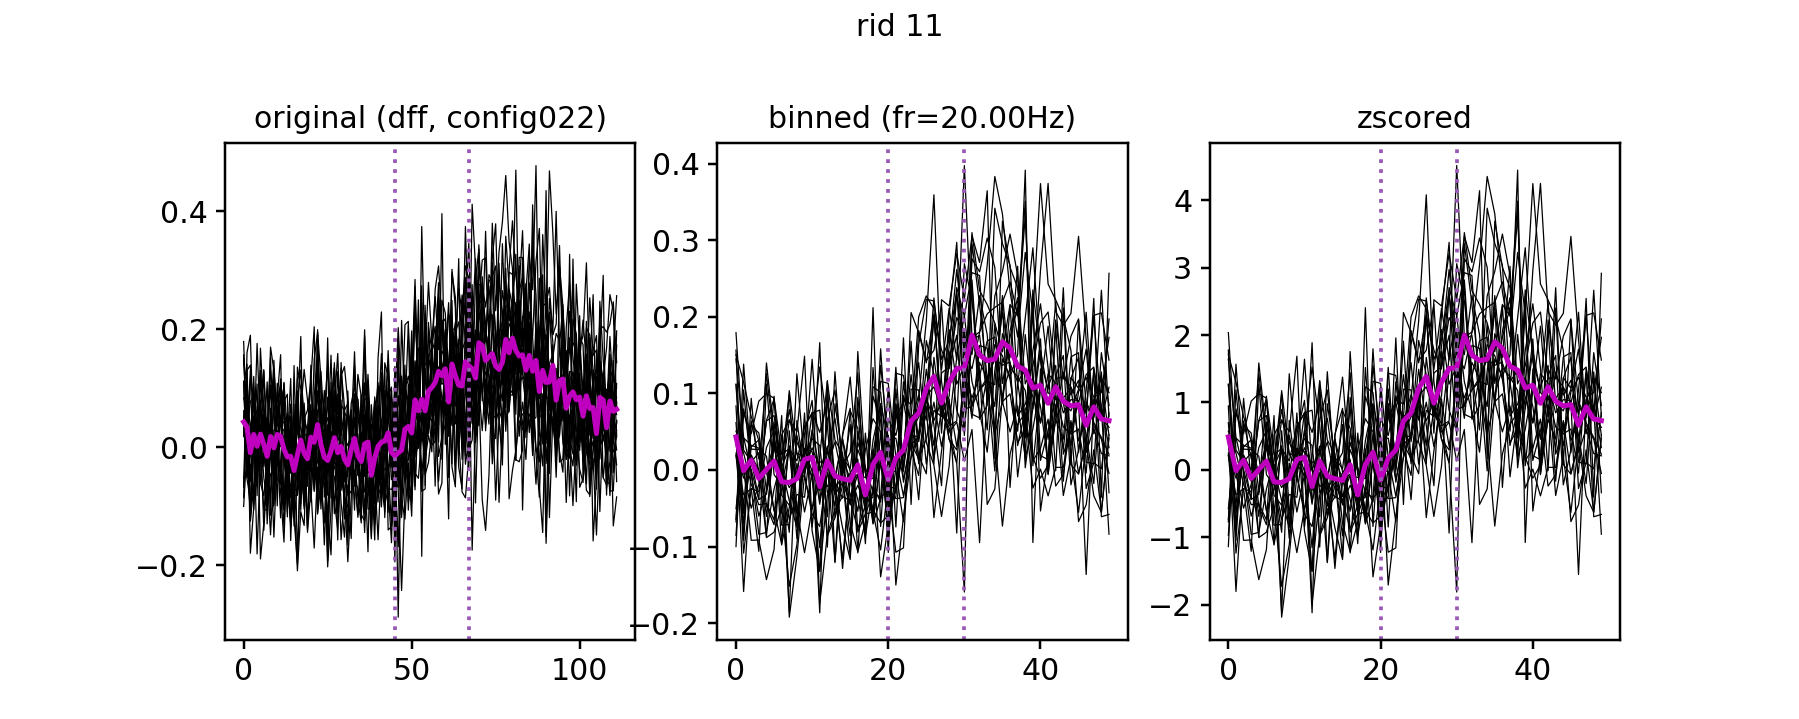

Text(0.5,0.98,u'rid 11')

In [136]:
print(trialmat.shape, binned_trialmat.shape)
#raw_ = trialmat.loc[included_trial_nums].copy()
#binned_ = binned_trialmat.loc[included_trial_nums].copy()
#zscored_ = zscored_neural.loc[included_trial_nums].copy()

fig, axn = pl.subplots(1, 3, figsize=(10,4))
ax=axn[0]; ax.set_title('original (%s, %s)' % (response_type, cfg));
ax.plot(trialmat.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(trialmat.loc[trial_ixs].values.T, axis=1), 'm', lw=2)
ax.axvline(x=stim_on, ls=':')
ax.axvline(x=stim_on+n_on, ls=':')

ax=axn[1]; ax.set_title('binned (fr=%.2fHz)' % (new_framerate));
ax.plot(binned_trialmat.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(binned_trialmat.loc[trial_ixs].values.T, axis=1), 'm', lw=2)
ax.axvline(x=new_stim_on, ls=':')
ax.axvline(x=new_stim_on+new_n_on, ls=':')


ax=axn[2]; ax.set_title('zscored');
ax.plot(zscored_neural.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(zscored_neural.loc[trial_ixs].values.T, axis=1), 'm', lw=2)
ax.axvline(x=new_stim_on, ls=':')
ax.axvline(x=new_stim_on+new_n_on, ls=':')

pl.subplots_adjust(top=0.8)
pl.suptitle('rid %i' % rid)


#### Match pupil framerate

In [137]:
labels.head()

config stim_dur       trial      tsec stim_on_frame nframes_on run_ix  \
0  config024      0.5  trial00001  -1.00784            45         22      0   
1  config024      0.5  trial00001 -0.985448            45         22      0   
2  config024      0.5  trial00001 -0.963051            45         22      0   
3  config024      0.5  trial00001 -0.940654            45         22      0   
4  config024      0.5  trial00001 -0.918258            45         22      0   

  file_ix  trial_num  
0       0          1  
1       0          1  
2       0          1  
3       0          1  
4       0          1

In [138]:
print(new_framerate)
#### Resample pupil
desired_nframes = len(out_ixs) # 60
binned_pupil = dlcutils.resample_pupil_traces(ptraces, in_rate=20.0, out_rate=new_framerate, 
                                     desired_nframes=desired_nframes)
binned_pupil['config'] = [trial_key[t] for t in binned_pupil['trial']]

20.0


In [139]:
binned_pupil.head()

trial  frame  pupil_area  frame_int  frame_ix     config
0      1      0  151.189627          0         0  config024
1      1      1  154.561072          1         1  config024
2      1      2  151.845837          2         2  config024
3      1      3  150.629278          3         3  config024
4      1      4  149.412676          4         4  config024

In [140]:
len(out_ixs)

50

In [141]:
pupil_trialmat = pd.DataFrame(np.vstack([p[feature_name].values for trial, p in binned_pupil.groupby(['trial'])]),
                              index=binned_trialmat.index, columns=binned_trialmat.columns)
print(pupil_trialmat.shape)


(1240, 50)


<IPython.core.display.Javascript object>


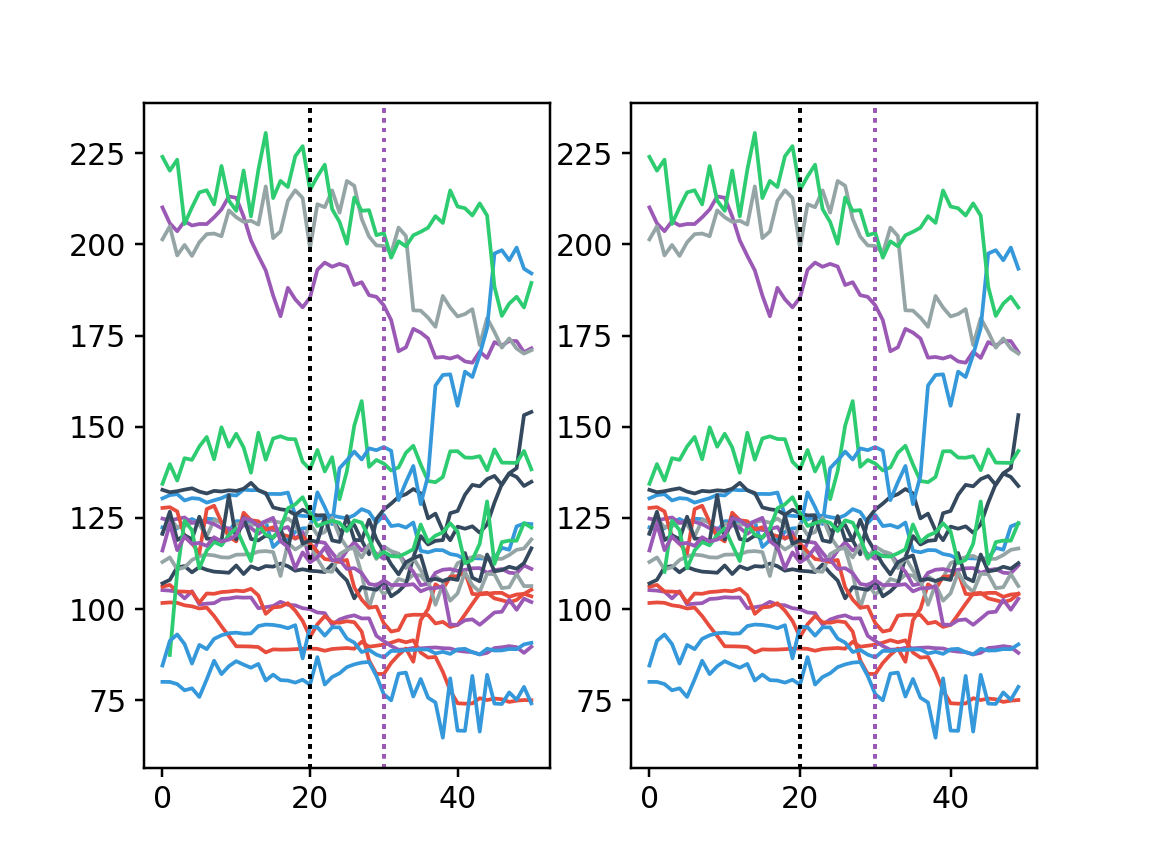

In [142]:
fig, axn = pl.subplots(1, 2)
ax=axn[0]
for t, pg in ptraces[ptraces['config']==cfg].groupby(['trial']):
    ixs = np.arange(0, len(pg[feature_name].values))
    ax.plot(ixs, pg[feature_name].values)
    ax.axvline(x=new_stim_on, ls=':', color='k')
    ax.axvline(x=new_stim_on+new_n_on, ls=':')

ax=axn[1]
for t, pg in binned_pupil[binned_pupil['config']==cfg].groupby(['trial']):
    ixs = np.arange(0, len(pg[feature_name].values))
    ax.plot(ixs, pg[feature_name].values)
    ax.axvline(x=new_stim_on, ls=':', color='k')
    ax.axvline(x=new_stim_on+new_n_on, ls=':')


In [65]:
binned_pupil.max(), binned_pupil.min()

(trial              1280
 frame                59
 pupil_area      1162.93
 frame_int            59
 frame_ix             59
 config        config064
 dtype: object, trial                 1
 frame                 0
 pupil_area      9.56755
 frame_int             0
 frame_ix              0
 config        config001
 dtype: object)

In [143]:
if experiment=='gratings':
    curr_sdf = sdf[(sdf['sf']==sf) & (sdf['speed']==speed)].copy()
    nr=8
    nc=2
else:
    curr_sdf = sdf.copy()
    nr=10
    nc=5
sdf_list = curr_sdf.index.tolist()
cfg_array = np.reshape(sdf_list, (nr,nc)).T
ri, ci = np.where(cfg_array=='config002')[0:]
print(ri, ci)

(array([0]), array([0]))


In [144]:
cfg_array

array([['config002', 'config010', 'config018', 'config026', 'config034',
        'config042', 'config050', 'config058'],
       ['config006', 'config014', 'config022', 'config030', 'config038',
        'config046', 'config054', 'config062']], dtype='|S9')

<IPython.core.display.Javascript object>


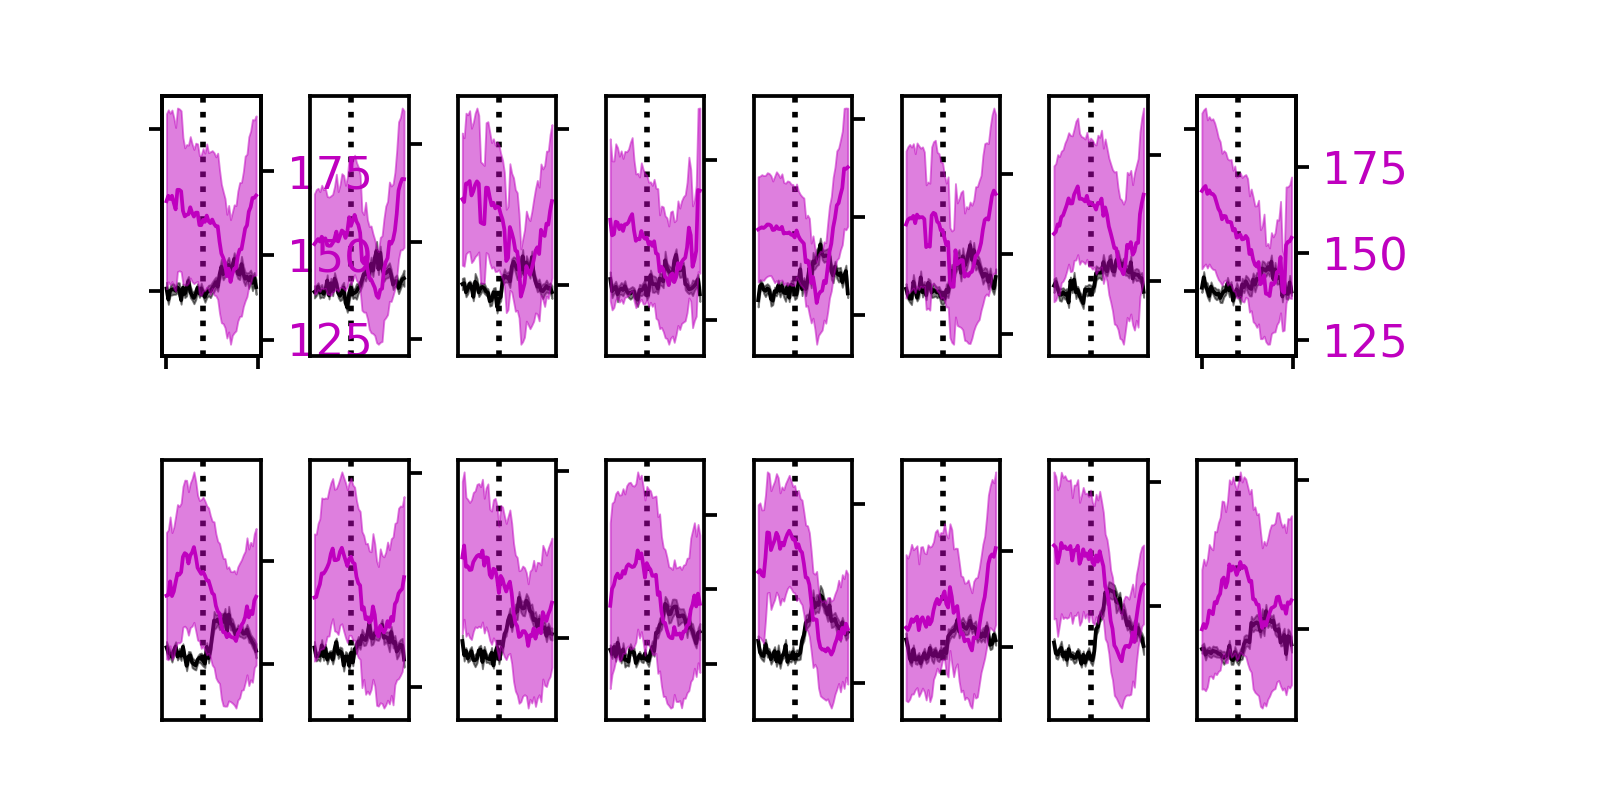

(array([0]), array([0]))
(array([0]), array([7]))


In [145]:
neural_color = 'k'
pupil_color = 'm'

fig, axn = pl.subplots(nc, nr, sharex=True, sharey=True, figsize=(6,3), dpi=dpi)
for cfg, t_df in binned_pupil.groupby(['config']):
    ri, ci = np.where(cfg_array==cfg)
    if len(ri)==0:
        continue
    if ci > (nr-1):
        break
    ax1 = axn[int(ri), int(ci)] #print(ri, ci)
    curr_trial_ixs = t_df['trial'].unique()
    #mean_neural_traces = np.nanmean(binned_trialmat.loc[curr_trial_ixs].values.T, axis=1)
    
    mean_neural_traces = binned_trialmat.loc[curr_trial_ixs].mean(axis=0).values
    ax1.plot(mean_neural_traces, lw=1, color=neural_color)
    n_sem = spstats.sem(binned_trialmat.loc[curr_trial_ixs].values, axis=0)
    ax1.fill_between(ixs, mean_neural_traces-n_sem, mean_neural_traces+n_sem, 
                    lw=.5, color=neural_color, alpha=0.5)
    ax1.set_ylim([-0.2, 0.6])
    ax1.tick_params(axis='y', labelcolor=neural_color)
    ax1.axvline(x=new_stim_on, ls=':', color='k')
    
    # pupil traces
    ax2 = ax1.twinx()  
    p_traces = np.vstack([g[feature_name].values for t, g in t_df.groupby(['trial'])])
    ntrials, nframes = p_traces.shape
    ixs = np.arange(0, nframes)

    ax2.plot(ixs, np.nanmean(p_traces, axis=0), lw=1, color=pupil_color)
    p_sem = spstats.sem(p_traces, axis=0, nan_policy='omit')
    ax2.fill_between(ixs, np.nanmean(p_traces, axis=0)-p_sem, np.nanmean(p_traces, axis=0)+p_sem, 
                    lw=.5, color=pupil_color, alpha=0.5)
    #ax.set_ylim([12, 25])
    #ax2.set_ylim([20, 35])
    ax2.tick_params(axis='y', labelcolor=pupil_color)
    
    if ri==0 and ci in [0, (nr-1)]:
        print(ri, ci)
    else:
        for ax in [ax1, ax2]:
            ax.set_ylabel('')
            ax.set_yticklabels([])
            ax.set_xlabel('')
            ax.set_xticklabels([])
            putils.turn_off_axis_ticks(ax1)
            
pl.subplots_adjust(wspace=0.5, hspace=0.4, left=0.1, right=0.8)


<IPython.core.display.Javascript object>


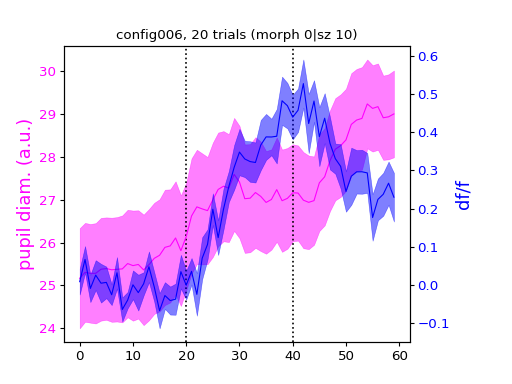

In [123]:
#for cfg, t_df in binned_pupil.groupby(['config']):
neural_color = 'blue'
pupil_color = 'magenta'

cfg = 'config006'
t_df = binned_pupil[binned_pupil['config']==cfg].copy()
cfg_ntrials = len(t_df['trial'].unique())


fig, ax =  pl.subplots()

p_traces = np.vstack([g['pupil'].values for t, g in t_df.groupby(['trial'])])
ntrials, nframes = p_traces.shape
ixs = np.arange(0, nframes)
ax.axvline(x=new_stim_on, ls=':', color='k')
ax.axvline(x=new_stim_on+new_n_on, ls=':', color='k')

# Plut pupil
ax.plot(ixs, p_traces.mean(axis=0), lw=1, color=pupil_color)
p_sem = spstats.sem(p_traces, axis=0)
ax.fill_between(ixs, p_traces.mean(axis=0)-p_sem, p_traces.mean(axis=0)+p_sem, 
                lw=.5, color=pupil_color, alpha=0.5)
#ax.set_ylim([12, 25])
ax.tick_params(which='both', axis='y', labelcolor=pupil_color)
ax.set_ylabel('pupil diam. (a.u.)', color=pupil_color)


ax2 = ax.twinx()  
curr_trial_ixs = t_df['trial'].unique()
#mean_neural_traces = np.nanmean(binned_trialmat.loc[curr_trial_ixs].values.T, axis=1)
mean_neural_traces = binned_trialmat.loc[curr_trial_ixs].mean(axis=0).values
ax2.plot(mean_neural_traces, lw=1, color=neural_color)
n_sem = spstats.sem(binned_trialmat.loc[curr_trial_ixs].values, axis=0)
ax2.fill_between(ixs, mean_neural_traces-n_sem, mean_neural_traces+n_sem, 
                lw=.5, color=neural_color, alpha=0.5)
ax2.tick_params(which='both', axis='y', labelcolor=neural_color)
#ax2.set_ylim([-0.05, 0.2])
ax2.set_ylabel('df/f', color=neural_color)

ax.set_title('%s, %i trials (morph %i|sz %i)' %(cfg, cfg_ntrials, sdf['morphlevel'][cfg], sdf['size'][cfg]))

#putils.label_figure(fig, '%s_%s' % (data_id, datakey))

pl.subplots_adjust(right=0.8)

<IPython.core.display.Javascript object>


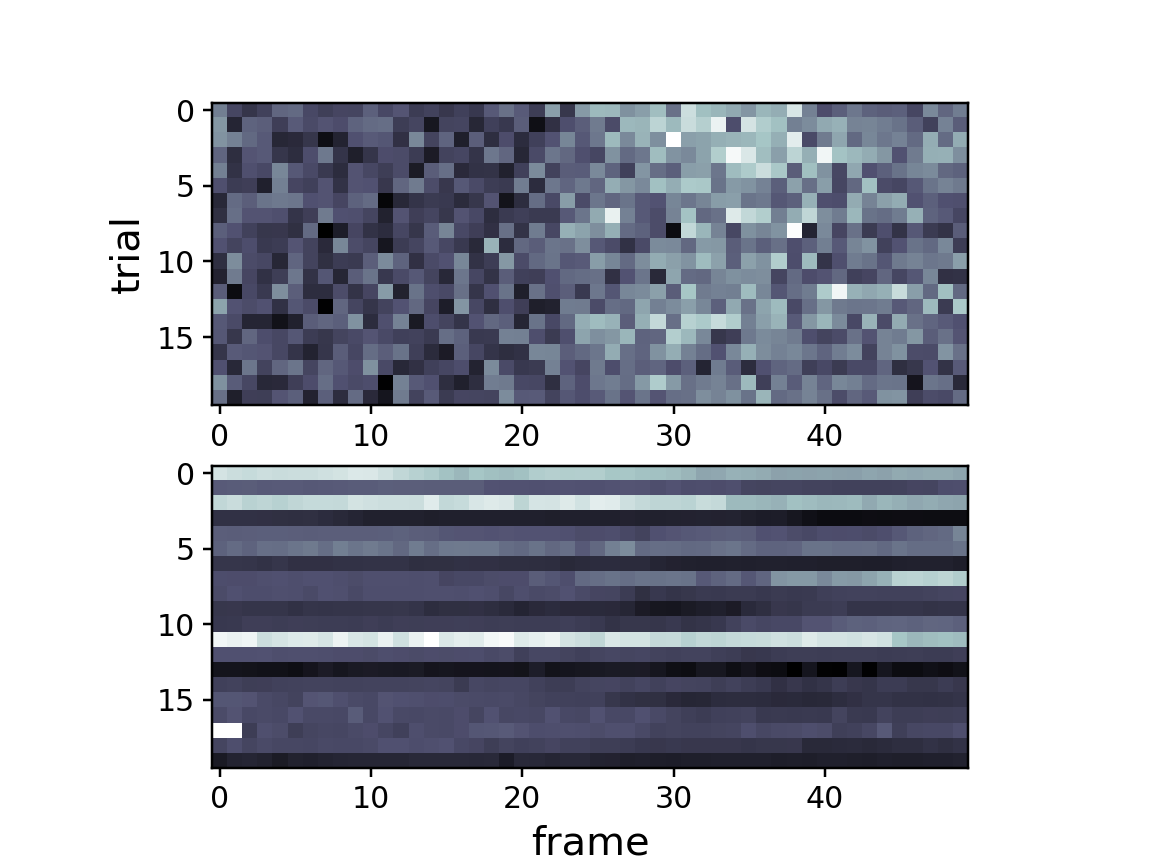

Text(0.5,0,u'frame')

In [146]:
fig, axn = pl.subplots(2, 1)
ax=axn[0]
ax.imshow(binned_trialmat.loc[trial_ixs], cmap='bone')
ax.set_ylabel('trial')

ax=axn[1]
ax.imshow(pupil_trialmat.loc[trial_ixs], cmap='bone')
ax.set_xlabel('frame')


In [336]:
binned_pupil.shape

(90000, 3)

In [70]:
pl.figure()
sns.heatmap(binned_pupil.groupby(['config']).mean()['pupil'].reshape((10, 5)).T)


<IPython.core.display.Javascript object>

KeyError: 'pupil'

# Predict pupil?

In [71]:
mean_pupils = binned_pupil.groupby(['config', 'trial']).mean().reset_index()
mean_pupils.shape

(1280, 6)

In [72]:
size_on_trials = [sdf['size'][c] for c in mean_pupils['config']]
morph_on_trials = [sdf['morphlevel'][c] for c in mean_pupils['config']]

mean_pupils['size'] = [sdf['size'][c] for c in mean_pupils['config']]
mean_pupils['morphlevel'] = [sdf['morphlevel'][c] for c in mean_pupils['config']]

fig, axn = pl.subplots(1, 2)
ax=axn[0]
sns.stripplot(x='size', y='pupil', hue='morphlevel', data=mean_pupils, ax=ax,
               marker='o', dodge=True)
ax=axn[1]
sns.stripplot(x='morphlevel', y='pupil', hue='size', data=mean_pupils, ax=ax,
               marker='o', dodge=True)


KeyError: 'morphlevel'

# Linear models

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics, linear_model, preprocessing
from sklearn.model_selection import StratifiedKFold


class Struct():
    pass

def fit_lasso_regr(xtrain, ytrain, xtest, ytest):
    regr = linear_model.Lasso()
    regr.fit(xtrain, ytrain)
    ypred = regr.predict(xtest)
    return ypred, regr

def fit_ridge_regr(xtrain, ytrain, xtest, ytest):
    regr = linear_model.Ridge()
    regr.fit(xtrain, ytrain)
    ypred = regr.predict(xtest)
    return ypred, regr

def fit_linear_regr(xtrain, ytrain, xtest, ytest):
    regr = linear_model.LinearRegression()
    regr.fit(xtrain, ytrain)
    ypred = regr.predict(xtest)
    return ypred, regr

def fit_logistic_regr(xtrain, ytrain, xtest, ytest):
    regr = linear_model.LogisticRegression()
    regr.fit(xtrain, ytrain)
    ypred = regr.predict(xtest)
    return ypred, regr


def get_regr_stats(X, ylabels, test_size=0.1, return_data=False, model='ols'):
    x_train, x_test, y_train, y_test = train_test_split(X, ylabels, test_size=test_size, random_state=0)
    if model=='ols':
        y_pred, regr = fit_linear_regr(x_train, y_train, x_test, y_test)
    elif model=='ridge':
        print("ridge")
        y_pred, regr = fit_ridge_regr(x_train, y_train, x_test, y_test)
    elif model=='lasso':
        print("lasso")
        y_pred, regr = fit_lasso_regr(x_train, y_train, x_test, y_test)
    elif model=='log':
        y_pred, regr = fit_logistic_regr(x_train, y_train, x_test, y_test)
        
        
    results = Struct()
    results.pearsons_r, results.pearsons_p = spstats.pearsonr(y_test, y_pred)
    results.exp_var = metrics.explained_variance_score(y_test, y_pred)
    results.mse = metrics.mean_squared_error(y_test, y_pred)
    results.r2 = metrics.r2_score(y_test, y_pred, multioutput='uniform_average')
    results.regr = regr
    results.prediction = y_pred
    results.true = y_test
    results.coef_ = regr.coef_
    results.intercept_ = regr.intercept_
    
    if return_data:
        data = {'x_train': x_train,
                'x_test': x_test,
                'y_train': y_train,
                'y_test': y_test}
        
        return results, data
    return results


ridge
ridge


<IPython.core.display.Javascript object>


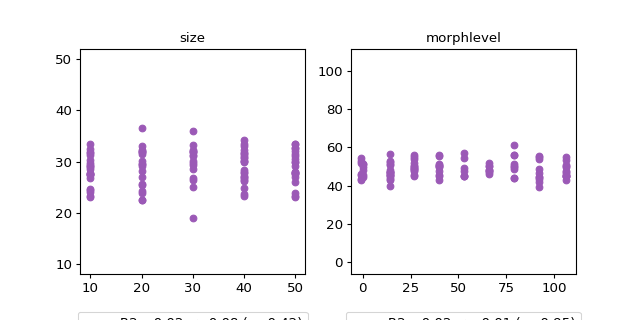

In [130]:
regr_var1 = 'size'
regr_var2 = 'morphlevel'
exclude_controls = True
model = 'ridge'

visual_areas = ['V1', 'Lm', 'Li']

targets1 = mean_pupils[regr_var1]
res1, data1 = get_regr_stats(mean_pupils['pupil'].reshape(-1, 1), targets1, return_data=True, model=model)

targets2 = mean_pupils[regr_var2]
res2, data2 = get_regr_stats(mean_pupils['pupil'].reshape(-1, 1), targets2, return_data=True, model=model)


# ---- plot --------------------------------------------__
fig, axes = pl.subplots(1, 2, figsize=(8,4))

ax = axes[0]
ax.set_title(regr_var1)
ax.scatter(res1.true, res1.prediction)
maxv = max([ax.get_xlim()[-1], ax.get_ylim()[-1]])
minv = min([ax.get_xlim()[0], ax.get_ylim()[0]])
ax.set_xlim([minv, maxv])
ax.set_ylim([minv, maxv])
pval_str = 'R2=%.2f, r=%.2f (p=%.2f)' % (res1.r2, res1.pearsons_r, res1.pearsons_p)
ax.plot(0, 0, alpha=0, label=pval_str)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.3), fontsize=12)

ax.set_aspect('equal')

ax = axes[1]
ax.set_title(regr_var2)
res_ = pd.DataFrame({'predicted': res2.prediction,
             'true': res2.true})
ax.scatter(res2.true, res2.prediction)
#sns.stripplot('true', 'predicted', data=res_, ax=ax, dodge=True)
maxv = max([ax.get_xlim()[-1], ax.get_ylim()[-1]])
minv = min([ax.get_xlim()[0], ax.get_ylim()[0]])
ax.set_xlim([minv, maxv])
ax.set_ylim([minv, maxv])
pval_str = 'R2=%.2f, r=%.2f (p=%.2f)' % (res2.r2, res2.pearsons_r, res2.pearsons_p)
ax.plot(0, 0, alpha=0, label=pval_str)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.3), fontsize=12)

ax.set_aspect('equal')



## Predict pupil from neural data

In [145]:
neuraldf.shape

(1005, 182)

In [146]:
datakey
roi_list = [r for r in neuraldf.columns if putils.isnumber(r)]
currdata = neuraldf[roi_list].copy()
X = pd.DataFrame(preprocessing.StandardScaler().fit_transform(currdata))


In [147]:
targets = mean_pupils['pupil'].copy()
res1, data1 = get_regr_stats(X, targets, return_data=True, model='ridge')


ridge


<IPython.core.display.Javascript object>


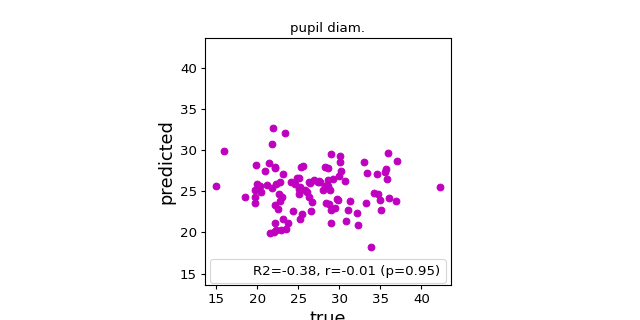

Text(0.5,0,u'true')

In [148]:
fig, ax = pl.subplots( figsize=(8,4))

ax.set_title('pupil diam.')
ax.scatter(res1.true, res1.prediction, c='m')
maxv = max([ax.get_xlim()[-1], ax.get_ylim()[-1]])
minv = min([ax.get_xlim()[0], ax.get_ylim()[0]])
ax.set_xlim([minv, maxv])
ax.set_ylim([minv, maxv])
pval_str = 'R2=%.2f, r=%.2f (p=%.2f)' % (res1.r2, res1.pearsons_r, res1.pearsons_p)
ax.plot(0, 0, alpha=0, label=pval_str)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.02), fontsize=12)
ax.set_aspect('equal')
ax.set_ylabel('predicted')
ax.set_xlabel('true')

#ax = putils.abline(res1.coef_, res1.intercept_, ax=ax, color='m')

# Get all rois and traces

In [147]:
pupil_r = pupil_trialmat.T.unstack().reset_index().rename(columns={'level_0': 'trial', 
                                                                   'level_1': 'frame',
                                                                   0: 'pupil'})
print(pupil_r.shape)



(62000, 3)


In [148]:
pupil_r['frame_int'] = [int(round(f)) for f in pupil_r['frame']]
interp_frame_ixs = list(sorted(pupil_r['frame'].unique()))
pupil_r['frame_ix'] = [interp_frame_ixs.index(f) for f in pupil_r['frame']]


In [149]:
r_list=[]
#rid=90
for rid in roi_list:
    # Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
    trialmat = pd.DataFrame(np.vstack([traces[rid][tg.index] for trial, tg in labels.groupby(['trial'])]),\
                            index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])
    configs_on_included_trials = [tg['config'].unique()[0] for trial, tg in labels.groupby(['trial'])]
    included_trials = [trial for trial, tg in labels.groupby(['trial'])]

    #### Bin traces - Each tbin is a column, each row is a sample 
#     sample_data = trialmat.fillna(method='pad').copy()
#     binned_trialmat = sample_data.T.groupby(np.arange(len(sample_data.columns))//n_frames_bin, axis=0).mean().T
#     n_tbins = np.ceil(trialmat.shape[1] / n_frames_bin)
    df = trialmat.fillna(method='pad').copy().T
    xdf = df.reindex(df.index.union(out_ixs)).interpolate('values').loc[out_ixs]
    binned_trialmat = xdf.T # should be Ntrials # Nframes
    n_tbins = binned_trialmat.shape[1]

    #### Zscore traces 
    zscored_neural = binned_trialmat / binned_trialmat.values.ravel().std()

    # Reshape roi traces
    cfg_list = np.hstack([[c for _ in np.arange(0, n_tbins)] for c in configs_on_included_trials])
    r_ = zscored_neural.T.unstack().reset_index() # level_0=trial number, level_1=frame number
    r_.rename(columns={'level_0': 'trial', 'level_1': 'frame', 0: rid}, inplace=True)
    r_list.append(r_)

# Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
trialmat = pd.DataFrame(np.vstack([traces[rid][tg.index] for trial, tg in labels.groupby(['trial'])]),\
                        index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])
configs_on_included_trials = [tg['config'].unique()[0] for trial, tg in labels.groupby(['trial'])]
included_trials = [trial for trial, tg in labels.groupby(['trial'])]


traces_r = pd.concat(r_list, axis=1)
print(r_.shape, traces_r.shape)
traces_r['config'] = cfg_list

_, dii = np.unique(traces_r.columns, return_index=True)
traces_r = traces_r.iloc[:, dii]
print(traces_r.shape)


((62000, 3), (62000, 345))
(62000, 118)


In [151]:
traces_r['frame_int'] = [int(round(f)) for f in traces_r['frame']]
interp_frame_ixs = list(sorted(pupil_r['frame'].unique()))
traces_r['frame_ix'] = [interp_frame_ixs.index(f) for f in traces_r['frame']]


#### Sort ROIs by correlation w/ pupil (for visualization)

In [152]:
pupil_values = pupil_r.sort_values(by=['trial', 'frame'])['pupil'].values

pupilcorrs = [np.corrcoef(traces_r.sort_values(by=['trial', 'frame_ix'])[rid], pupil_values)[0, 1] for rid in roi_list]


In [153]:
sorted_ixs = np.argsort(pupilcorrs)
# for ri in sorted_ixs:
#     print(ri, roi_list[ri], pupilcorrs[ri])
sorted_rids = np.array([roi_list[ri] for ri in sorted_ixs[::-1]])

In [154]:
# from matplotlib.colors import LinearSegmentedColormap

# cmap_name='nic_edge'
# cmap_dir='/n/coxfs01/julianarhee/aggregate-visual-areas/colormaps'

# #colormap = 'nic_Edge'
# #cmapdir = os.path.join(aggr_dir, 'colormaps')
# cdata = np.loadtxt(os.path.join(cmap_dir, cmap_name) + ".txt")
# cmap = LinearSegmentedColormap.from_list('my_colormap', cdata) #[::-1])
cmap='seismic'

In [155]:
new_stim_on, new_n_on

(20, 10)

In [156]:
on_frames = np.arange(new_stim_on, new_stim_on+new_n_on)
print(len(on_frames))
on_frames


10


array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [157]:
iti_pre, iti_post

(1.0, 1.0)

<IPython.core.display.Javascript object>


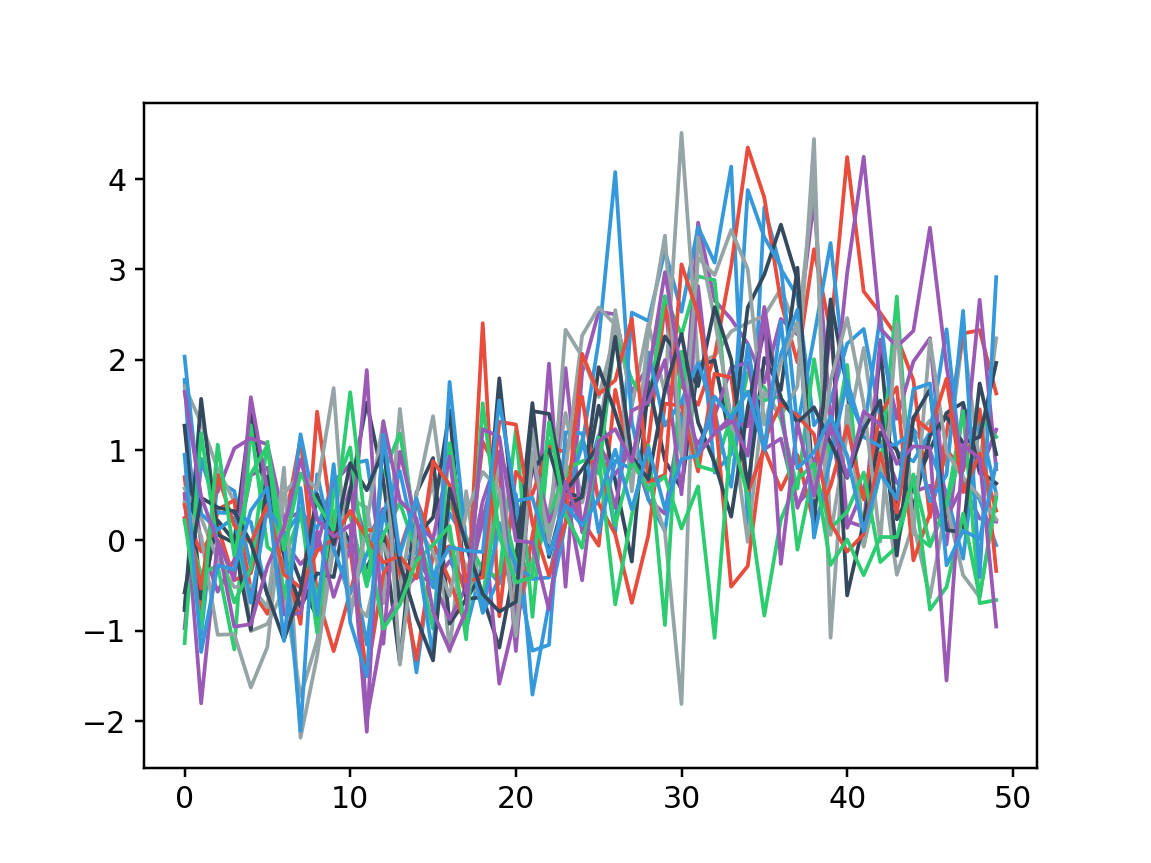

In [161]:
rid=11
f, ax = pl.subplots()
test = traces_r[traces_r['config']=='config022'][[rid, 'trial']]
for t, tr in test.groupby(['trial']):
    ax.plot(tr[rid].values)
    
  

In [159]:
stim_ixs

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

<IPython.core.display.Javascript object>


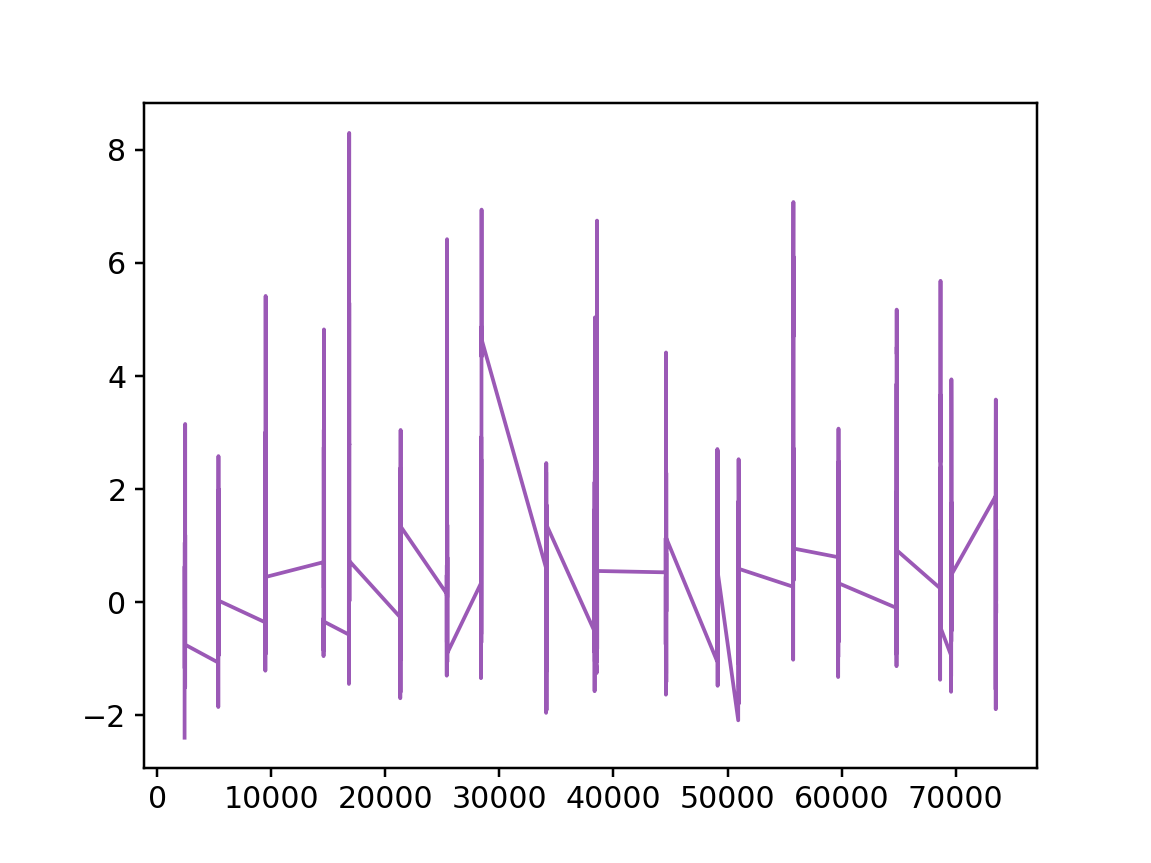

In [105]:
pl.figure()
pl.plot(traces_r[traces_r['trial'].isin(curr_trial_ixs)][sorted_rids].T.loc[123])

In [162]:
# plot_config = 'config022'
# plot_config = 'config020'

#plot_config='config006'

plot_config='config022'
#plot_config = None

if plot_config is not None:
    trial_ixs = traces_r[traces_r['config']==plot_config]['trial'].unique()
    #trial_ixs = sorted(pupil_r[pupil_r['trial'].isin(curr_trials)].unique())
else:
    trial_ixs = sorted(pupil_r['trial'].unique())

ntrials_plot = 30 if plot_config is None else len(trial_ixs)
start_trial = 0

plot_str = plot_config if plot_config is not None else 'consecutivetrials'
print(plot_str)

curr_trial_ixs = trial_ixs[start_trial:start_trial+ntrials_plot] if plot_config is None else trial_ixs
print("[%s] %i trials" % (plot_config, len(curr_trial_ixs)))


config022
[config022] 20 trials


<IPython.core.display.Javascript object>


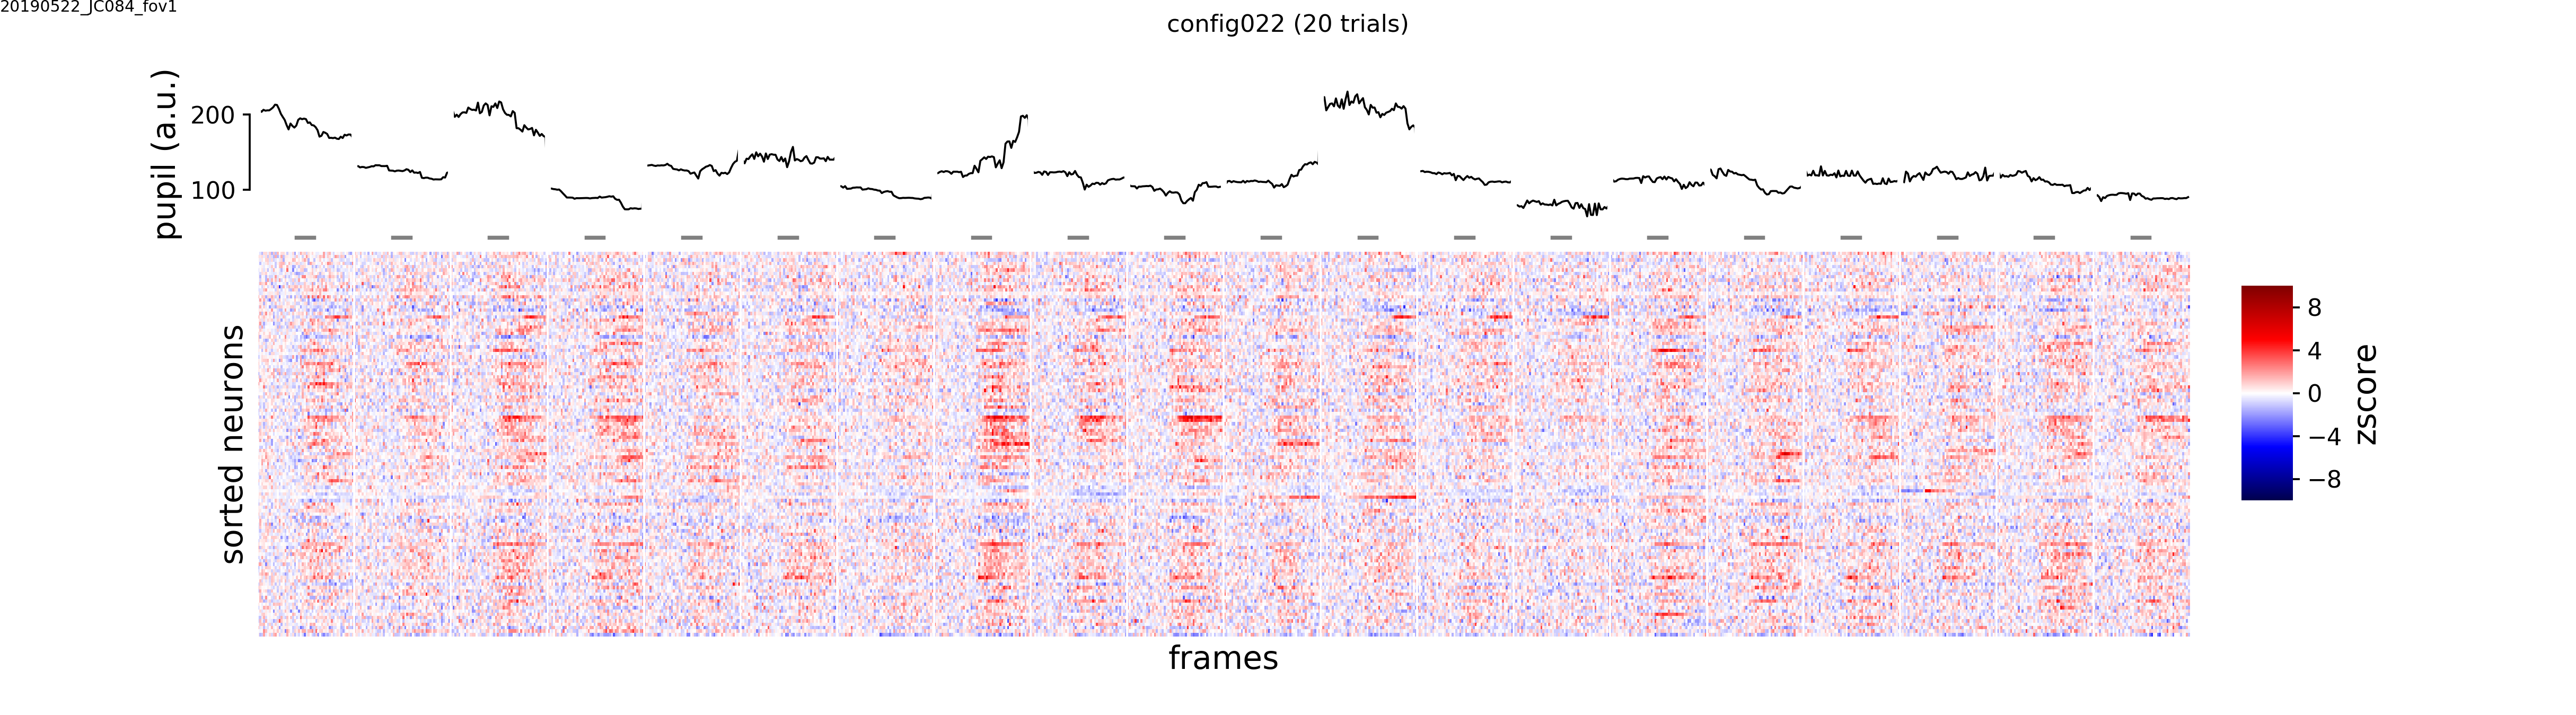

('/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/pupil', 'gratings_20190522_JC084_fov1_config022_sorted_neurons_pupil_trace_20trials_bin20fHz')


In [163]:

pupil_lw=1
stim_lw=2

curr_pupil_trace = pupil_r[pupil_r['trial'].isin(curr_trial_ixs)]['pupil'].values
stim_ixs = [1 if f in on_frames else np.nan for f in pupil_r[pupil_r['trial'].isin(curr_trial_ixs)]['frame_ix']]

curr_p = pupil_r[pupil_r['trial'].isin(curr_trial_ixs)].copy()
ix = curr_p.index.tolist()
on_ixs_global = [ix.index(i) for i in curr_p[curr_p['frame']==0].index.tolist()]
pvs = curr_pupil_trace.copy()
# pvs[on_ixs_global] = np.nan



#fig, ax = pl.subplots()
grid_kws = {"height_ratios": (.25, 0.05, .7), "hspace": .005}
fig, (ax1, stimax, ax0) = pl.subplots(3,1, gridspec_kw=grid_kws, figsize=(18,5), dpi=dpi, sharex=True)

# Plot neural traces (all neurons, sorted) as heatmap
cbar_ax = fig.add_axes([.87, .3, .02, .3])
im0 = sns.heatmap(traces_r[traces_r['trial'].isin(curr_trial_ixs)][sorted_rids].T, ax=ax0,
                  cmap=cmap, center=0, vmin=-10, vmax=10,
                  cbar_ax=cbar_ax, cbar_kws={'label': 'zscore'})
for ix in on_ixs_global:
    ax0.axvline(x=ix, color='w', lw=1)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_ylabel('sorted neurons')
ax0.set_xlabel('frames')



# Plot pupil traces
nframes_total=len(pupil_r)
#divider = make_axes_locatable(ax)
#topax = divider.append_axes("top", 1.2, pad=0.5, sharex=None) #scatterax) #None)
ax1.plot(np.arange(0, len(curr_pupil_trace)), pvs, lw=pupil_lw, color='k')
ax1.set_ylabel('pupil (a.u.)')
#ax1.set_ylim([0, 45])
for ix in on_ixs_global:
    ax1.axvline(x=ix, color='w', lw=3)
    
    
# Plot stimulus onset bars
stimax.plot(np.arange(0, len(curr_pupil_trace)), stim_ixs, color='gray', lw=stim_lw)
stimax.tick_params(which='both', axis='both', size=0)
stimax.axis('off')

sns.despine(trim=True, bottom=True, ax=ax1, offset=4)
ax1.tick_params(axis='x', which='both', size=0)
ax1.set_xticks([])
pl.subplots_adjust(left=0.1, right=0.85)
fig.suptitle('%s (%i trials)' % (plot_str, ntrials_plot))

putils.label_figure(fig, '%s' % ( datakey))

figname = '%s_%s_%s_sorted_neurons_pupil_trace_%itrials_bin%ifHz' % (experiment, datakey, plot_str, ntrials_plot, new_framerate)
pl.savefig(os.path.join(pupildir, '%s.png' % figname))
print(pupildir, figname)

In [167]:
rid=38
np.where(sorted_rids==rid)


(array([67]),)

In [82]:
pupildir

'/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/pupil'

# Predict timecourse of pupil from neural data?

In [169]:
from sklearn.model_selection import GroupKFold

In [170]:
print(traces_r.shape, pupil_r.shape)
traces_r.head()


((60300, 186), (60300, 5))


10        11        12        13        14        15        16  \
0  0.169547  0.472849 -0.386613  0.186729 -1.292843  0.078211  0.842616   
1 -0.979956  0.620085 -0.180696 -1.643719  0.819454  1.089016  1.073829   
2  0.625777  0.100512 -0.119508 -0.853918 -0.258440 -0.771667  0.598990   
3 -0.494210  0.849788 -0.329372  1.522356 -0.077400 -0.739375  0.107661   
4 -0.958328  0.263749  0.895011  0.260934  1.409682  0.855343 -1.119126   

         19        21        23    ...          373       376       378  \
0  2.109420 -0.480554  0.063928    ...    -1.722240  0.649570 -0.092068   
1 -0.696182  0.256776  0.453960    ...    -0.386238 -0.175722  0.080225   
2  1.043337 -0.359412  0.147162    ...     0.394601  1.330416  0.990328   
3 -2.112934  1.052569 -0.200632    ...    -1.083106  0.799715  0.106565   
4  0.683626  0.715992  1.123732    ...     0.332844 -0.567338  0.475594   

        381       385     config     frame  trial  frame_int  frame_ix  
0  0.171097  1.783301  config041  0.000000      1          0         0  
1  1.805510 -0.687990  config041  2.271186      1          2         1  
2 -0.507790  0.051501  config041  4.542373      1          5         2  
3  0.522096  1.237979  config041  6.813559      1          7         3  
4  1.993931  0.130783  config041  9.084746      1          9         4  

[5 rows x 186 columns]

In [171]:
pupil_r.head()

trial     frame  pupil  frame_int  frame_ix
0      1  0.000000    NaN          0         0
1      1  2.271186    NaN          2         1
2      1  4.542373    NaN          5         2
3      1  6.813559    NaN          7         3
4      1  9.084746    NaN          9         4

In [172]:
groups = pupil_r['trial']
group_kfold = GroupKFold(n_splits=2)

X = traces_r.copy() #[roi_list].copy()
y = pupil_r['pupil'].values

group_kfold.get_n_splits(X, y, groups)
for train_index, test_index in group_kfold.split(X, y, groups):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print(X_train, X_test)

In [175]:
rid=38
curr_cfg='config006'

<IPython.core.display.Javascript object>


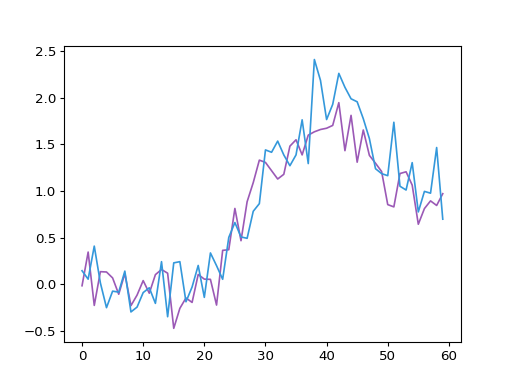

In [176]:
pl.figure()
pl.plot(np.vstack([g[rid] for v, g in X_train[X_train['config']==curr_cfg].groupby(['trial'])]).mean(axis=0))
pl.plot(np.vstack([g[rid] for v, g in X_test[X_test['config']==curr_cfg].groupby(['trial'])]).mean(axis=0))



In [177]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

import scipy.stats as spstats
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

import sklearn.metrics as skmetrics

In [190]:
roi_list = [r for r in traces_r.columns if putils.isnumber(r)]
train_x, test_x, train_y, test_y = train_test_split(traces_r[roi_list], pupil_r['pupil'], test_size=0.2)


In [191]:
traces_r.shape, train_x.shape, test_x.shape

((60300, 186), (48240, 181), (12060, 181))

In [198]:
train_x.shape, train_x.dropna().shape

((48240, 181), (48240, 181))

In [199]:
train_y.shape, train_y.dropna().shape

((48240,), (48201,))

In [200]:
#### DATA - Fit classifier
scaler = StandardScaler()
scaler.fit(train_x)

#### DATA - Test with held-out data
test_data = scaler.transform(test_x)
trained_svc = LinearRegression().fit(train_x, train_y.interpolate())
test_score = trained_svc.score(test_x, test_y.interpolate())
print(test_score)

0.0448352807888


In [201]:
predicted_labels = trained_svc.predict(test_data) #, test_labels)

In [202]:
len(predicted_labels), len(test_labels)

(12060, 30180)

<IPython.core.display.Javascript object>


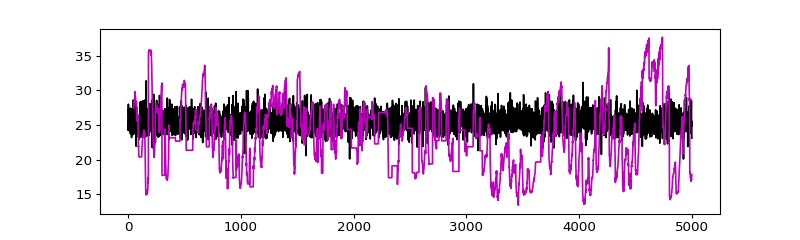

In [203]:
pl.figure(figsize=(10,3))
pl.plot(predicted_labels[0:5000], 'k')
pl.plot(test_labels[0:5000], 'm')

In [189]:
test_x.head()

10        11        12        13        14        15        16  \
29993 -0.344347 -0.183358  1.079199  0.833466  0.065819 -0.061201 -0.625916   
28835 -1.185820  0.583444 -0.973081 -1.014400 -0.856453 -1.330389 -0.771786   
46992 -0.941707  0.351665  0.364944 -0.381946  1.220894  0.273174 -0.228947   
23933  0.125047  0.158719  1.475127 -0.305028  0.102875 -0.452364  1.066503   
30922  1.483705 -0.118953  3.253140  1.186680 -1.252638  0.867138 -0.206187   

             19        21        23    ...          373       376       378  \
29993 -0.131529  0.114518 -1.472525    ...    -0.047481  0.299905 -0.006329   
28835 -0.199246  0.592250 -0.023945    ...     0.967329  0.382904 -0.421438   
46992  0.612653  0.284786  0.259929    ...     0.504911 -1.707302  0.660455   
23933 -0.781784  1.045899  0.263506    ...    -0.870245 -1.289549 -1.909297   
30922 -2.168936  1.123760  2.897217    ...    -0.142491 -2.390858  0.332039   

            381       385     config       frame  trial  frame_int  frame_ix  
29993 -1.549801  0.798815  config007  120.372881    647        120        53  
28835 -0.805807 -0.323440  config046   79.491525    628         79        35  
46992 -0.600637  0.301963  config022   27.254237   1079         27        12  
23933  0.150488  1.068907  config020  120.372881    545        120        53  
30922  0.042195  1.231186  config017   49.966102    663         50        22  

[5 rows x 186 columns]

In [180]:
roi_list = [r for r in traces_r.columns if putils.isnumber(r)]


In [181]:
iter_results=[]
# Get data and labels
groups = pupil_r['trial']
group_kfold = GroupKFold(n_splits=2)

X = traces_r.copy() #[roi_list].copy()
y = pupil_r['pupil'].values
roi_list = [r for r in traces_r.columns if putils.isnumber(r)]

group_kfold.get_n_splits(X, y, groups)
for train_index, test_index in group_kfold.split(X, y, groups):
    X_train, X_test = X.loc[train_index][roi_list], X.loc[test_index][roi_list]
    train_labels, test_labels = y[train_index], y[test_index]
    #print(X_train, X_test)

    #### DATA - Fit classifier
    scaler = StandardScaler()
    scaler.fit(X_train)
    train_data = scaler.transform(X_train)
    svc = LinearRegression() #, penalty='l2')
    scores = cross_validate(svc, train_data, train_labels, cv=5,
                            scoring=('r2', 'neg_mean_squared_error'),
                            return_train_score=True)
    iterdict = dict((s, values.mean()) for s, values in scores.items())

    #### DATA - Test with held-out data
    test_data = scaler.transform(X_test)
    trained_svc = LinearRegression().fit(train_data, train_labels)
    test_score = trained_svc.score(test_data, test_labels)

    #### DATA - Calculate MI
    predicted_labels = trained_svc.predict(test_data)
    mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
    ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
    log2_mi = computeMI(test_labels, predicted_labels)

    iterdict.update({'heldout_test_score': test_score, 
                     'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
    iter_results.append(pd.DataFrame(iterdict, index=[iteration]))


# #% Train/validation split
# n_splits = 5 #len(X)
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) #KFold(n_splits=n_splits)
# kf.get_n_splits(train_x) #(X)

# # Do K-fold CV for current stimulus configs
# scores=[]
# test_scores = [] #dict((tv, []) for tv in tested_sizes)
# for train_index, validate_index in kf.split(train_x, train_y): #(X, y): #kf.split(X):

#     # Get current train/validate split data
# #                     X_train, X_validate = X[train_index], X[validate_index]
# #                     y_train, y_validate = y[train_index], y[validate_index]
#     X_train, X_validate = train_x[train_index], train_x[validate_index]
#     y_train, y_validate = train_y[train_index], train_y[validate_index]

#     scaler = preprocessing.StandardScaler().fit(X_train)
#     X_train_transformed = scaler.transform(X_train)

#     # Fit SVM
#     trained_svc = LinearRegression(C=C_value).fit(X_train_transformed, y_train)

#     # Validate with held-out data
#     X_validate_transformed = scaler.transform(X_validate)
#     curr_score = trained_svc.score(X_validate_transformed, y_validate)  
#     y_pred = trained_svc.predict(X_validate_transformed)

#     # Add current fold score
#     test_scores.append(curr_score)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [174]:
scores

{'fit_time': array([ 1.441787  ,  2.05968404,  1.5969429 ,  1.73612309,  1.71120906]),
 'score_time': array([ 0.00806689,  0.00947094,  0.01095319,  0.02040505,  0.00982285]),
 'test_neg_mean_squared_error': array([-24.47388561, -27.39212099, -33.33938681, -32.01179972, -37.24117864]),
 'test_r2': array([-0.03276524,  0.07701976, -0.00049881,  0.03276712,  0.06353265]),
 'train_neg_mean_squared_error': array([-30.2575073 , -29.39523891, -27.97060108, -28.34635655, -27.00753485]),
 'train_r2': array([ 0.11476885,  0.11188175,  0.13035   ,  0.11321507,  0.11473068])}

# Create data frames for pupil/neural data - test low/high pupil

In [204]:

curr_rois = cells[cells['datakey']==datakey]['cell'].values
curr_cols = list(curr_rois.copy())
neuraldf = MEANS[datakey][curr_cols].copy()
neuraldf['config'] = MEANS[datakey]['config'].copy()
print(neuraldf.shape)
neuraldf = neuraldf.loc[trials_with_pupil]


(1500, 182)


In [205]:
# neuraldf = pd.concat([g[roi_list].mean(axis=0) for t, g in traces_r.groupby(['trial'])], axis=1).T
# print(neuraldf.shape)
# config_list = [g['config'].unique()[0] for t, g in traces_r.groupby(['trial'])]
#print(datakey)
#neuraldf=MEANS[datakey].copy()

pupildf = pd.concat([g.mean(axis=0) for t, g in pupil_r.groupby(['trial'])], axis=1).T
print(pupildf.shape)


(1005, 5)


In [206]:
print(neuraldf.shape)

(1005, 182)


## Subdivide pupil levels into high/low

In [207]:
pupil_quantiles = pupildf.pupil.quantile([0.25,0.5,0.75])

<IPython.core.display.Javascript object>


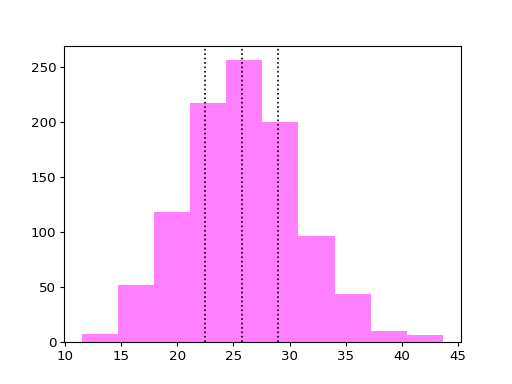

In [208]:
fig, ax = pl.subplots()
ax.hist(pupildf['pupil'], color='magenta', alpha=0.5)
for v in pupil_quantiles:
    ax.axvline(x=v, ls=':', color='k')

# Classifier

In [209]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

import scipy.stats as spstats
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import sklearn.metrics as skmetrics

In [210]:
import sklearn.metrics as skmetrics
import random

def computeMI(x, y):
    sum_mi = 0.0
    x_value_list = np.unique(x)
    y_value_list = np.unique(y)
    Px = np.array([ len(x[x==xval])/float(len(x)) for xval in x_value_list ]) #P(x)
    Py = np.array([ len(y[y==yval])/float(len(y)) for yval in y_value_list ]) #P(y)
    for i in xrange(len(x_value_list)):
        if Px[i] ==0.:
            continue
        sy = y[x == x_value_list[i]]
        if len(sy)== 0:
            continue
        pxy = np.array([len(sy[sy==yval])/float(len(y))  for yval in y_value_list]) #p(x,y)
        t = pxy[Py>0.]/Py[Py>0.] /Px[i] # log(P(x,y)/( P(x)*P(y))
        sum_mi += sum(pxy[t>0]*np.log2( t[t>0]) ) # sum ( P(x,y)* log(P(x,y)/( P(x)*P(y)) )
    return sum_mi

In [211]:
def fit_svm(curr_data, sdf, m0=0, m100=106, C_value=1.0, n_iterations=100):
    iter_results=[]
    iter_results_chance=[]
    for iteration in np.arange(0, n_iterations):

        #### Select train/test configs for clf A vs B
        object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
        curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
        sample_data = curr_data[curr_data['config'].isin(object_configs)]

        #### Equalize df/f across neurons:  Normalize each neuron to have same (zero) mean, (unit) SD across stimuli
        data = sample_data[curr_roi_list]
        zdata = (data - data.mean()) / data.std()


        #### Get labels
        targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
        targets['label'] = [sdf['morphlevel'][cfg] for cfg in targets['config'].values]
        targets['group'] = [sdf['size'][cfg] for cfg in targets['config'].values]

        stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
        sizes = sorted(stimdf['size'].unique())

        #### For each transformation, split trials into 80% and 20%
        train_data=[]; test_data=[]; 
        train_labels=[]; test_labels=[]; 
        train_data_chance=[]; test_data_chance=[]; 
        train_labels_chance=[]; test_labels_chance=[]; 
        train_data, test_data, train_labels, test_labels = train_test_split(zdata, targets['label'].values, 
                                                            test_size=0.2, stratify=targets['group'])


#         for sz in sizes: 
#             curr_configs = sdf[sdf['size']==sz].index.tolist()
#             curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
#             xi = zdata.loc[curr_trials]
#             yi = targets.loc[curr_trials]['label'].values

#             # Split train/test
#             train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2, startify=)
#             train_data.append(train_x)
#             test_data.append(test_x)
#             train_labels.append(train_y)
#             test_labels.append(test_y)
#         # Aggregate TRAIN/TEST data   
#         train_data = np.vstack(train_data)
#         train_labels = np.hstack(train_labels)
#         test_data = np.vstack(test_data)
#         test_labels = np.hstack(test_labels)

        #### DATA - Fit classifier
        scaler = StandardScaler()
        scaler.fit(train_data)
        train_data = scaler.transform(train_data)
        svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
        scores = cross_validate(svc, train_data, train_labels, cv=5,
                                scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                return_train_score=True)
        iterdict = dict((s, values.mean()) for s, values in scores.items())

        #### DATA - Test with held-out data
        test_data = scaler.transform(test_data)
        trained_svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels)
        test_score = trained_svc.score(test_data, test_labels)

        #### DATA - Calculate MI
        predicted_labels = trained_svc.predict(test_data)
        mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
        ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
        log2_mi = computeMI(test_labels, predicted_labels)

        iterdict.update({'heldout_test_score': test_score, 
                         'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
        iter_results.append(pd.DataFrame(iterdict, index=[iteration]))

        # ------------------------------------------------------------------
        # Shuffle LABELS to calculate chance level
        train_labels_chance = train_labels.copy()
        np.random.shuffle(train_labels_chance)
        test_labels_chance = test_labels.copy()
        np.random.shuffle(test_labels_chance)

        #### CHANCE - Fit classifier
        svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
        scores_chance = cross_validate(svc, train_data, train_labels_chance, cv=5,
                                scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                return_train_score=True)
        iterdict_chance = dict((s, values.mean()) for s, values in scores_chance.items())

        # CHANCE - Test with held-out data
        trained_svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels_chance)
        test_score_chance = trained_svc_chance.score(test_data, test_labels_chance)  

        # Chance - Calculate MI
        predicted_labels = trained_svc_chance.predict(test_data)
        mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
        ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
        log2_mi = computeMI(test_labels, predicted_labels)

        iterdict_chance.update({'heldout_test_score': test_score_chance, 
                                'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
        iter_results_chance.append(pd.DataFrame(iterdict_chance, index=[iteration]))

    # DATA - get mean across iters
    df = pd.concat(iter_results, axis=0)
    df_chance = pd.concat(iter_results_chance, axis=0)
    
    return df, df_chance


# def fit_svm(curr_data, sdf, m0=0, m100=106, C_value=1.0, n_iterations=100):

#     iter_results=[]
#     iter_results_chance=[]
#     for iteration in np.arange(0, n_iterations):

#         #### Select train/test configs for clf A vs B
#         object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
#         curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
#         sample_data = curr_data[curr_data['config'].isin(object_configs)]

#         #### Equalize df/f across neurons:  Normalize each neuron to have same (zero) mean, (unit) SD across stimuli
#         zdata = sample_data[curr_roi_list]
#         #zdata = (data - data.mean()) / data.std()

#         #### Get labels
#         targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
#         targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

#         stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
#         sizes = sorted(stimdf['size'].unique())

#         #### For each transformation, split trials into 80% and 20%
#         train_data=[]; test_data=[]; 
#         train_labels=[]; test_labels=[]; 
#         train_data_chance=[]; test_data_chance=[]; 
#         train_labels_chance=[]; test_labels_chance=[]; 
#         for sz in sizes: 
#             curr_configs = sdf[sdf['size']==sz].index.tolist()
#             curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
#             xi = zdata.loc[curr_trials]
#             yi = targets.loc[curr_trials]['label'].values

#             # Split train/test
#             train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2)
#             train_data.append(train_x)
#             test_data.append(test_x)
#             train_labels.append(train_y)
#             test_labels.append(test_y)

#         # Aggregate TRAIN/TEST data        
#         train_data = np.vstack(train_data)
#         train_labels = np.hstack(train_labels)
#         test_data = np.vstack(test_data)
#         test_labels = np.hstack(test_labels)

#         #### DATA - Fit classifier
#         svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
#         scores = cross_validate(svc, train_data, train_labels, cv=5,
#                                 scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
#                                 return_train_score=True)
#         iterdict = dict((s, values.mean()) for s, values in scores.items())

#         #### DATA - Test with held-out data
#         trained_svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels)
#         test_score = trained_svc.score(test_data, test_labels)

#         #### DATA - Calculate MI
#         predicted_labels = trained_svc.predict(test_data)
#         mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
#         ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
#         log2_mi = computeMI(test_labels, predicted_labels)

#         iterdict.update({'heldout_test_score': test_score, 
#                          'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
#         iter_results.append(pd.DataFrame(iterdict, index=[iteration]))

#         # ------------------------------------------------------------------
#         # Shuffle LABELS to calculate chance level
#         train_labels_chance = train_labels.copy()
#         np.random.shuffle(train_labels_chance)
#         test_labels_chance = test_labels.copy()
#         np.random.shuffle(test_labels_chance)

#         #### CHANCE - Fit classifier
#         svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
#         scores_chance = cross_validate(svc, train_data, train_labels_chance, cv=5,
#                                 scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
#                                 return_train_score=True)
#         iterdict_chance = dict((s, values.mean()) for s, values in scores_chance.items())

#         # CHANCE - Test with held-out data
#         trained_svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels_chance)
#         test_score_chance = trained_svc_chance.score(test_data, test_labels_chance)  

#         # Chance - Calculate MI
#         predicted_labels = trained_svc_chance.predict(test_data)
#         mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
#         ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
#         log2_mi = computeMI(test_labels, predicted_labels)

#         iterdict_chance.update({'heldout_test_score': test_score_chance, 
#                                 'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
#         iter_results_chance.append(pd.DataFrame(iterdict_chance, index=[iteration]))

#     # DATA - get mean across iters
#     df = pd.concat(iter_results, axis=0)
#     df_chance = pd.concat(iter_results_chance, axis=0)
    
#     return df, df_chance


In [212]:
low_pupil_thr = pupil_quantiles[0.25]
high_pupil_thr = pupil_quantiles[0.75]

pupil_low = pupildf[pupildf['pupil']<low_pupil_thr].copy()
pupil_high = pupildf[pupildf['pupil']>high_pupil_thr].copy()

# Get trial indices of low/high pupil 
low_trial_ixs = sorted(pupil_low['trial'].unique())
high_trial_ixs = sorted(pupil_high['trial'].unique())

#print(pupil_low.shape, pupil_high.shape)


In [213]:
m0=0
m100=106
C_value=1

n_iterations = 50

In [214]:
curr_data = neuraldf.copy()
df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)

# Fit LOW
curr_data = neuraldf.loc[low_trial_ixs].copy()
lo, lo_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)


# Fit HIGH
curr_data = neuraldf.loc[high_trial_ixs].copy()
hi, hi_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)

In [215]:

metric='heldout_test_score'
print("all: %.2f (chance=%.2f)" % (df.mean()[metric], df_chance.mean()[metric]))
print("low: %.2f (chance=%.2f)" % (lo.mean()[metric], lo_chance.mean()[metric]))
print("high: %.2f (chance=%.2f)" % (hi.mean()[metric], hi_chance.mean()[metric]))


all: 0.64 (chance=0.50)
low: 0.65 (chance=0.51)
high: 0.56 (chance=0.56)


In [216]:
dsets

animalid experiment            fov   session visual_area  fovnum  \
0     JC076      blobs  FOV1_zoom2p0x  20190420          V1       1   
3     JC076      blobs  FOV1_zoom2p0x  20190502          Li       1   
5     JC078      blobs  FOV1_zoom2p0x  20190430          Lm       1   
8     JC078      blobs  FOV1_zoom2p0x  20190504          Lm       1   
11    JC080      blobs  FOV1_zoom2p0x  20190506          Lm       1   
14    JC083      blobs  FOV1_zoom2p0x  20190507          V1       1   
17    JC083      blobs  FOV1_zoom2p0x  20190508          Lm       1   
22    JC083      blobs  FOV1_zoom2p0x  20190512          Lm       1   
26    JC084      blobs  FOV1_zoom2p0x  20190522          V1       1   
30    JC084      blobs  FOV1_zoom2p0x  20190525          Lm       1   
35    JC085      blobs  FOV1_zoom2p0x  20190622          V1       1   
39    JC090      blobs  FOV1_zoom2p0x  20190605          Li       1   
44    JC091      blobs  FOV1_zoom2p0x  20190602          Li       1   
48    JC091      blobs  FOV1_zoom2p0x  20190606          Li       1   
52    JC091      blobs  FOV1_zoom2p0x  20190627          Lm       1   
57    JC097      blobs  FOV1_zoom2p0x  20190613          V1       1   
62    JC097      blobs  FOV1_zoom2p0x  20190616          V1       1   
66    JC097      blobs  FOV1_zoom2p0x  20190617          V1       1   
71    JC097      blobs  FOV1_zoom2p0x  20190618          Lm       1   
75    JC099      blobs  FOV1_zoom2p0x  20190609          Li       1   
79    JC099      blobs  FOV1_zoom2p0x  20190617          Li       1   
84    JC110      blobs  FOV1_zoom2p0x  20191006          V1       1   
88    JC113      blobs  FOV1_zoom2p0x  20191018          Li       1   
92    JC117      blobs  FOV1_zoom2p0x  20191105          Li       1   
96    JC120      blobs  FOV1_zoom2p0x  20191111          Li       1   

                datakey  
0   20190420_JC076_fov1  
3   20190502_JC076_fov1  
5   20190430_JC078_fov1  
8   20190504_JC078_fov1  
11  20190506_JC080_fov1  
14  20190507_JC083_fov1  
17  20190508_JC083_fov1  
22  20190512_JC083_fov1  
26  20190522_JC084_fov1  
30  20190525_JC084_fov1  
35  20190622_JC085_fov1  
39  20190605_JC090_fov1  
44  20190602_JC091_fov1  
48  20190606_JC091_fov1  
52  20190627_JC091_fov1  
57  20190613_JC097_fov1  
62  20190616_JC097_fov1  
66  20190617_JC097_fov1  
71  20190618_JC097_fov1  
75  20190609_JC099_fov1  
79  20190617_JC099_fov1  
84  20191006_JC110_fov1  
88  20191018_JC113_fov1  
92  20191105_JC117_fov1  
96  20191111_JC120_fov1

In [217]:
segmented_datakeys = cells['datakey'].unique()


In [218]:
m0=0
m100=106
C_value=1
n_iterations = 50
skip = [] # ['20190420_JC076_fov1']


not_segmented=[]

curr_dsets = dsets.copy() #dsets[dsets['visual_area']=='V1'].copy()
d_list=[]; d_list_chance=[]; dkeys=[];
lo_list=[]; lo_list_chance=[]; 
hi_list=[]; hi_list_chance=[]; 
n_datakeys = len(curr_dsets['datakey'].unique())

for di, (datakey, ds) in enumerate(curr_dsets.groupby(['datakey'])):
    if datakey not in segmented_datakeys:
        not_segmented.append(datakey)
        continue
    
    if di % 5 == 0:
        print("%i of %i datakeys" % (int(di+1), n_datakeys))
        
    #neuraldf = MEANS[datakey].copy() 
    curr_rois = cells[cells['datakey']==datakey]['cell'].values
    curr_cols = list(curr_rois.copy())
    neuraldf = MEANS[datakey][curr_cols].copy()
    neuraldf['config'] = MEANS[datakey]['config'].copy()
    print(neuraldf.shape)

    # ------ PUPIL --------------------------------------------------
    pupiltraces = PUPIL['%s_%s' % (datakey, experiment)].copy()
    # Resample pupil traces
    binned_pupil = resample_pupil_traces(pupiltraces, in_rate=20.0, out_rate=new_framerate)
    # binned_trialmat.shape # Ntrials # Nframes
    trials_ = sorted(pupiltraces['trial'].unique())
    new_nframes_per_trial = binned_pupil.shape[0]/float(len(trials_))
    frames_ = np.arange(0, new_nframes_per_trial)
    pupil_trialmat = pd.DataFrame(np.vstack([p['pupil'].values for trial, p in binned_pupil.groupby(['trial'])]),
                                  index=trials_, columns=frames_)
                                  #index=binned_trialmat.index, columns=binned_trialmat.columns)
    pupil_r = pupil_trialmat.T.unstack().reset_index().rename(columns={'level_0': 'trial', 
                                                                   'level_1': 'frame',
                                                                   0: 'pupil'})
    pupildf = pd.concat([g.mean(axis=0) for t, g in pupil_r.groupby(['trial'])], axis=1).T
    trials_with_pupil = list(pupildf['trial'].unique())
    neuraldf=neuraldf.loc[trials_with_pupil]
    
    # ------ Split trials by quantiles ---------------------------------
    pupil_quantiles = pupildf.pupil.quantile([0.25,0.5,0.75])
    low_pupil_thr = pupil_quantiles[0.25]
    high_pupil_thr = pupil_quantiles[0.75]
    pupil_low = pupildf[pupildf['pupil']<low_pupil_thr].copy()
    pupil_high = pupildf[pupildf['pupil']>high_pupil_thr].copy()

    # Get trial indices of low/high pupil 
    low_trial_ixs = sorted(pupil_low['trial'].unique())
    high_trial_ixs = sorted(pupil_high['trial'].unique())
    
    # Fit all
    curr_data = neuraldf.copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("all: %.2f (chance=%.2f)" % (df.mean()['heldout_aMI'], df_chance.mean()['heldout_aMI']))
    d_list.append(df.mean(axis=0).T)
    d_list_chance.append(df_chance.mean(axis=0).T)
    
    # Fit LOW
    curr_data = neuraldf.loc[low_trial_ixs].copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("low: %.2f (chance=%.2f)" % (df.mean()['heldout_aMI'], df_chance.mean()['heldout_aMI']))
    lo_list.append(df.mean(axis=0).T)
    lo_list_chance.append(df_chance.mean(axis=0).T)
    
    # Fit LOW
    curr_data = neuraldf.loc[high_trial_ixs].copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("high: %.2f (chance=%.2f)" % (df.mean()['heldout_aMI'], df_chance.mean()['heldout_aMI']))
    hi_list.append(df.mean(axis=0).T)
    hi_list_chance.append(df_chance.mean(axis=0).T)
    
    dkeys.append(datakey)


(1500, 178)


KeyboardInterrupt: 

In [228]:
print(d_list[0].shape)
full_df = pd.concat(d_list, axis=1).T
full_chance = pd.concat(d_list_chance, axis=1).T
full_df['datakey'] = dkeys
full_chance['datakey'] = dkeys

lo_df = pd.concat(lo_list, axis=1).T
lo_chance = pd.concat(lo_list_chance, axis=1).T
lo_df['datakey'] = dkeys
lo_chance['datakey'] = dkeys

hi_df = pd.concat(hi_list, axis=1).T
hi_chance = pd.concat(hi_list_chance, axis=1).T
hi_df['datakey'] = dkeys
hi_chance['datakey'] = dkeys



(12,)


In [301]:
full_df.head()

fit_time  heldout_MI  heldout_aMI  heldout_log2MI  heldout_test_score  \
0  0.004758    0.346440     0.495467        0.499807            0.883333   
1  0.006810    0.206706     0.290534        0.298214            0.799000   
2  0.006232    0.115261     0.156263        0.166286            0.726000   
3  0.009844    0.196752     0.276214        0.283853            0.794667   
4  0.009995    0.129689     0.177963        0.187102            0.742333   

   score_time  test_accuracy  test_neg_mean_squared_error   test_r2  \
0    0.000863       0.808250                 -2154.507472  0.232264   
1    0.000899       0.769239                 -2592.829378  0.076043   
2    0.000891       0.703518                 -3331.269901 -0.186951   
3    0.001849       0.744406                 -2871.858744 -0.023066   
4    0.002172       0.709607                 -3262.854956 -0.162705   

   train_accuracy  train_neg_mean_squared_error  train_r2              datakey  
0        0.966761                   -373.468449  0.866928  20190507_JC083_fov1  
1        0.930379                   -782.257217  0.721258  20190522_JC084_fov1  
2        0.884893                  -1293.341367  0.539197  20190613_JC097_fov1  
3        0.960357                   -445.425505  0.841325  20190616_JC097_fov1  
4        0.967491                   -365.268858  0.869845  20190622_JC085_fov1

In [304]:
metric='heldout_test_score'

m_ = pd.concat([full_df[[metric]], lo_df[metric], hi_df[metric]], axis=1)
m_.columns = ['all', 'low', 'high']
# m_df['datakey'] = full_df['datakey']
m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})

m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]


<IPython.core.display.Javascript object>


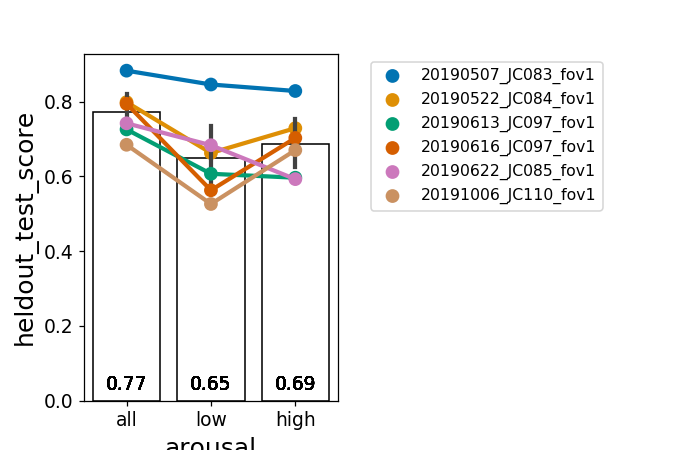

In [305]:
fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, palette='colorblind',
             s=10)
sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
            edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
ax.legend(bbox_to_anchor=(1.1, 1))

pl.subplots_adjust(right=0.5)

<IPython.core.display.Javascript object>


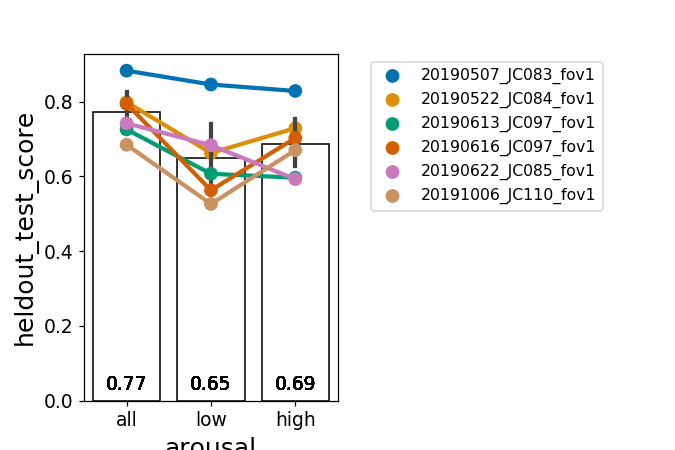

In [306]:
fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, palette='colorblind',
             s=10)
sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
            edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
ax.legend(bbox_to_anchor=(1.1, 1))

pl.subplots_adjust(right=0.5)

<IPython.core.display.Javascript object>


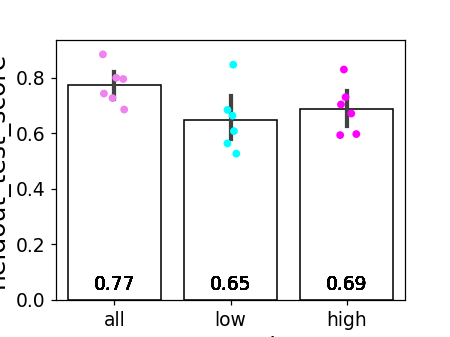

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
dtype: object

In [307]:
pupil_colors={'all': 'violet', 'low': 'aqua', 'high': 'magenta'}
fig, ax = pl.subplots(figsize=(4,3), dpi=dpi)
sns.stripplot(x='arousal', y=metric, data=m_df, ax=ax, palette=pupil_colors)
sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
            edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')


In [293]:
multi_comp_test='fdr_bh'
# Annotate w stats
print("********* [%s|%s] *********" % (experiment, metric))
#y_loc = 16 if fov_means else 23
statresults = aggr.do_mannwhitney(m_df, metric=metric, multi_comp_test=multi_comp_test)
aggr.annotate_stats_areas(statresults, ax) #, y_loc=y_loc, offset=1)


********* [blobs|heldout_aMI] *********


KeyError: 'visual_area'

# Load RF data

In [ ]:
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.rois.utils import load_roi_coords

In [ ]:
reliable_only = True
#rfs_filter_by = None # Get all # match <EXP> datasets # 'drop_repeats'
rf_fit_thr = 0.05
fit_desc = fitrf.get_fit_desc(response_type=response_type)
reliable_str = 'reliable' if reliable_only else ''
rf_str = 'match%s_%s' % (experiment, reliable_str)
print(rf_str)


#### Get non-repeated FOV datasets
rf_dsets = sdata_exp[(sdata_exp['datakey'].isin(stim_datakeys))
                     & (sdata_exp['experiment'].isin(['rfs', 'rfs10']))].copy()
rf_dpaths, no_fits = rfutils.get_fit_dpaths(rf_dsets, traceid=traceid, fit_desc=fit_desc)
print("%i with no fits" % len(no_fits))

rfdf = rfutils.aggregate_rf_data(rf_dpaths, reliable_only=reliable_only, fit_desc=fit_desc,
                                            traceid=traceid, verbose=False)
rfdf = rfdf.reset_index(drop=True)

#### Get position info

In [ ]:
#if get_positions:
print("Calculating RF coord conversions...")
pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
for p in pos_params:
    rfdf[p] = ''
p_list=[]
for (animalid, session, fovnum), g in rfdf.groupby(['animalid', 'session', 'fovnum']):
    fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                              traceid=traceid, create_new=False)

    for ei, e_df in g.groupby(['experiment']):
        cell_ids = e_df['cell'].unique()
        p_ = fcoords['roi_positions'].loc[cell_ids]
        for p in pos_params:
            rfdf[p][e_df.index] = p_[p].values
# with open(df_fpath, 'wb') as f:
#     pkl.dump(expdf, f, protocol=pkl.HIGHEST_PROTOCOL)

#### Select subset of RF data

In [ ]:
r_list=[]
for datakey, expdf in corrs.groupby(['datakey']):
    # Get active blob cells
    exp_rids = sorted(np.union1d(expdf['row'].unique(), expdf['col'].unique()))    
    # Get current fov's RFs
    rdf = rfdf[rfdf['datakey']==datakey].copy()
    
    # If have both rfs/rfs10, pick the best one
    if len(rdf['experiment'].unique())>1:
        rf_rids = rdf[rdf['experiment']=='rfs']['cell'].unique()
        rf10_rids = rdf[rdf['experiment']=='rfs10']['cell'].unique()
        same_as_rfs = np.intersect1d(rf_rids, exp_rids)
        same_as_rfs10 = np.intersect1d(rf10_rids, exp_rids)
        rfname = 'rfs' if len(same_as_rfs) > len(same_as_rfs10) else 'rfs10'
        print("Selecting %s, overlappig rfs, %i | rfs10, %i (of %i cells)" 
              % (rfname, len(same_as_rfs), len(same_as_rfs10), len(exp_rids)))
        r_list.append(rdf[rdf['experiment']==rfname])
    else:
        r_list.append(rdf)
RFs = pd.concat(r_list, axis=0)


#### Calculate overlap 

In [ ]:
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
n_dks = len(RFs['datakey'].unique())

o_list=[]
for di, ((visual_area, animalid, session, fovnum, datakey), g) in enumerate(RFs.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey'])):
    if di%10==0:
        print("... %i of %i" % (int(di+1), n_dks))
        
    # convert RF fit params to polygon
    g.index = g['cell'].values
    rf_polys = rfutils.rfs_to_polys(g[rf_fit_params])

    # Get all pairwise overlaps (% of smaller ellipse that overlaps larger ellipse)
    pair_ixs = list(itertools.combinations(np.arange(0, len(rf_polys)), 2))
    overlaps = pd.concat([rfutils.get_proportion_overlap(rf_polys[p1], rf_polys[p2]) for (p1, p2) in pair_ixs], axis=0)
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    o_ = putils.add_meta_to_df(overlaps, metadict)
    o_list.append(o_)

overlaps = pd.concat(o_list, axis=0).reset_index(drop=True)